# Predicting invasive ductal carcinoma in tissue slices

The dataset used consists of 162 whole mount Breast Histopathology slide images of Breast Cancer (BCa) specimens. There were then 277,524 patches of size 50 x 50 created from the original slide images. Each of the patches are labelled as IDC or non-IDC. Try to classify each image as Invasive Ductal Carcinoma (IDC) or Non-IDC using Machine Learning techniques such as Convolutional Neural Networks.




Original dataset link; https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

## Downloading the Dataset

Instructions:


1.   Make an account on Kaggle.com.
2.   Click on your profile picture and click on Settings from the drop-down menu.
3.   Scroll down to the API section.
4.   Click on the ‘Create New API Token’ button to download a fresh token as a JSON file having a username and API key.
5.   Copy the JSON file to ~/.kaggle/ the directory.
6.   Run the cell block below. Select the kaggle.json file from your computer when prompted.



In [ ]:
! pip install -q kaggle #installing required libraries

In [ ]:
from google.colab import files
files.upload() #upload your kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emmetcampbell22","key":"4723b131bebfef2b60b5f27e1bc9ec60"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/ #copy your kaggle.json file to ~/.kaggle/ directory
! chmod 600 ~/.kaggle/kaggle.json #security
! kaggle datasets download -d 'paultimothymooney/breast-histopathology-images'

100% 3.10G/3.10G [01:25<00:00, 38.1MB/s]
100% 3.10G/3.10G [01:25<00:00, 38.9MB/s]


In [ ]:
#unzip the data
! unzip breast-histopathology-images.zip -d breast-histopathology-images

Streaming output truncated to the last 5000 lines.
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: breast-histopathology-images/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.p

This notebook is based on https://www.kaggle.com/code/allunia/breast-cancer notebook.

# Preparation  <a class="anchor" id="prep"></a>

## Loading packages and setting <a class="anchor" id="setup"></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

import seaborn as sns

### Settings

In [ ]:
run_training = True
retrain = False
find_learning_rate = False

## Exploring the data structure <a class="anchor" id="explorestructure"></a>

In [ ]:
files = listdir("./breast-histopathology-images/")
print(len(files))

280


In [ ]:
files[0:10]

['15633',
 '14306',
 '9178',
 '9319',
 '9382',
 '16531',
 '16166',
 '8955',
 '16569',
 '8957']

These are patient ids. For each patient we have an individual subfolder that contains image patches.

### How many patients do we have?

In [ ]:
base_path = "./breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### How many patches do we have in total?


In [ ]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [ ]:
total_images

277524

There are approx. 280000 images. 

Store the path of each image to load batches of images only one by one.

### Storing the image_path, patient_id and the target

In [ ]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1

data.head()

patient_id                                               path target
0      15633  ./breast-histopathology-images/IDC_regular_ps5...      0
1      15633  ./breast-histopathology-images/IDC_regular_ps5...      0
2      15633  ./breast-histopathology-images/IDC_regular_ps5...      0
3      15633  ./breast-histopathology-images/IDC_regular_ps5...      0
4      15633  ./breast-histopathology-images/IDC_regular_ps5...      0

# Exploratory analysis <a class="anchor" id="eda"></a>


Extract some statistics for the dataset

In [ ]:
print("Num of patients: ", data["patient_id"].nunique())
print("Num of patches: ", data.shape[0])
print('Number of non-IDC patches: {}'.format(np.sum(data["target"]=='0')))
print('Number of IDC patches: {}'.format(np.sum(data["target"]=='1')))
print('Percentage of non-IDC patches: {:.2f}%'.format(100*(len(data[data["target"]=='0'])/data.shape[0])))
print('Percentage of IDC patched: {:.2f}%'.format(100*(len(data[data["target"]=='1'])/data.shape[0])))
print('Average number of patches per patient: {:.2f}'.format(data.shape[0]/data["patient_id"].nunique()))
print('Average number of non-IDC patches per patient: {:.2f}'.format(np.sum(data["target"]=='0')/data["patient_id"].nunique()))
print('Average number of IDC patches per patient: {:.2f}'.format(np.sum(data["target"]=='1')/data["patient_id"].nunique()))

Num of patients:  279
Num of patches:  277524
Number of non-IDC patches: 0
Number of IDC patches: 0
Percentage of non-IDC patches: 0.00%
Percentage of IDC patched: 0.00%
Average number of patches per patient: 994.71
Average number of non-IDC patches per patient: 0.00
Average number of IDC patches per patient: 0.00


The dataset contains whole slide images (WSI) from 279 patients and from those images 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). The percentage of negative and positive IDC patches is 71.61% and 28.39% respectively. In addition the average number of patches for each patient is 994.71. For these the 712.32 is the non-IDC (negative) patches and 282.39 is for IDC patches.

Compute the percentage of patches per each class (non-IDC and IDC)

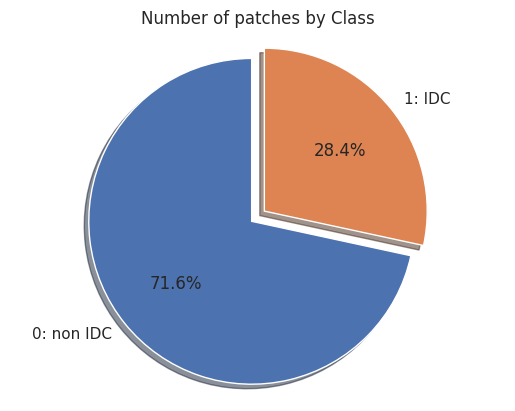

In [ ]:
# Pie chart (Number of patches For Each Class)
labels = "0: non IDC", "1: IDC"
result = [np.sum(data["target"]=='0'), np.sum(data["target"]=='1')]
total = result[0] + result[1]
sizes = [result[0]/total, result[1]/total]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Number of patches by Class")
plt.show()
#plt.savefig("number_of_samples_breakdown")

There are **71.6%** non-IDC patches and **28.4%** IDC patches. The dataset might be considered to be unbalanced.

Compute for each patient: the number of negative / positive patches, the total number of patches and the ratio of (IDC) positive patches to non-IDC (negative) patches (let's call it IDC_ratio)

In [ ]:
# compute for each patient the number of negative/positive patches
parts = data.groupby(['patient_id', 'target']).size().unstack(fill_value=0)
parts['IDC_ratio'] = parts['1']/parts['0']
# compute the count of total patches per patient
totals = data.groupby('patient_id')['target'].count()

# Merge the series into one dataframe that uses the same index
data_summary = pd.concat([parts['0'], parts['1'], totals, parts['IDC_ratio']],axis = 1)
data_summary.columns = ['n_0_patches/patient', 'n_1_patches/patient', 'n_patches/patient','IDC_ratio']

In [ ]:
data_summary.head()

n_0_patches/patient  n_1_patches/patient  n_patches/patient  \
patient_id                                                                
10253                       479                   70                549   
10254                       772                   76                848   
10255                       181                   91                272   
10256                       351                  117                468   
10257                       427                  208                635   

            IDC_ratio  
patient_id             
10253        0.146138  
10254        0.098446  
10255        0.502762  
10256        0.333333  
10257        0.487119

In [ ]:
data_summary['patient_id'] = data_summary.index

Produce statistical summary

In [ ]:
# Produce statistical summary
display (data_summary.describe())

n_0_patches/patient  n_1_patches/patient  n_patches/patient   IDC_ratio
count           279.000000           279.000000         279.000000  279.000000
mean            712.322581           282.387097         994.709677    0.656702
std             476.404878           259.236512         550.603474    0.897750
min              14.000000            10.000000          63.000000    0.010544
25%             347.500000           104.500000         560.500000    0.160497
50%             623.000000           198.000000         967.000000    0.363515
75%             998.500000           369.500000        1362.000000    0.806853
max            2231.000000          1347.000000        2395.000000    9.363636

Visualize the boxplots of the number of negative patches, the number of positive patches for all patients, the total number of patches and the positive to negative ratio (let's call it idc_ratio)

<Axes: ylabel='IDC_ratio'>

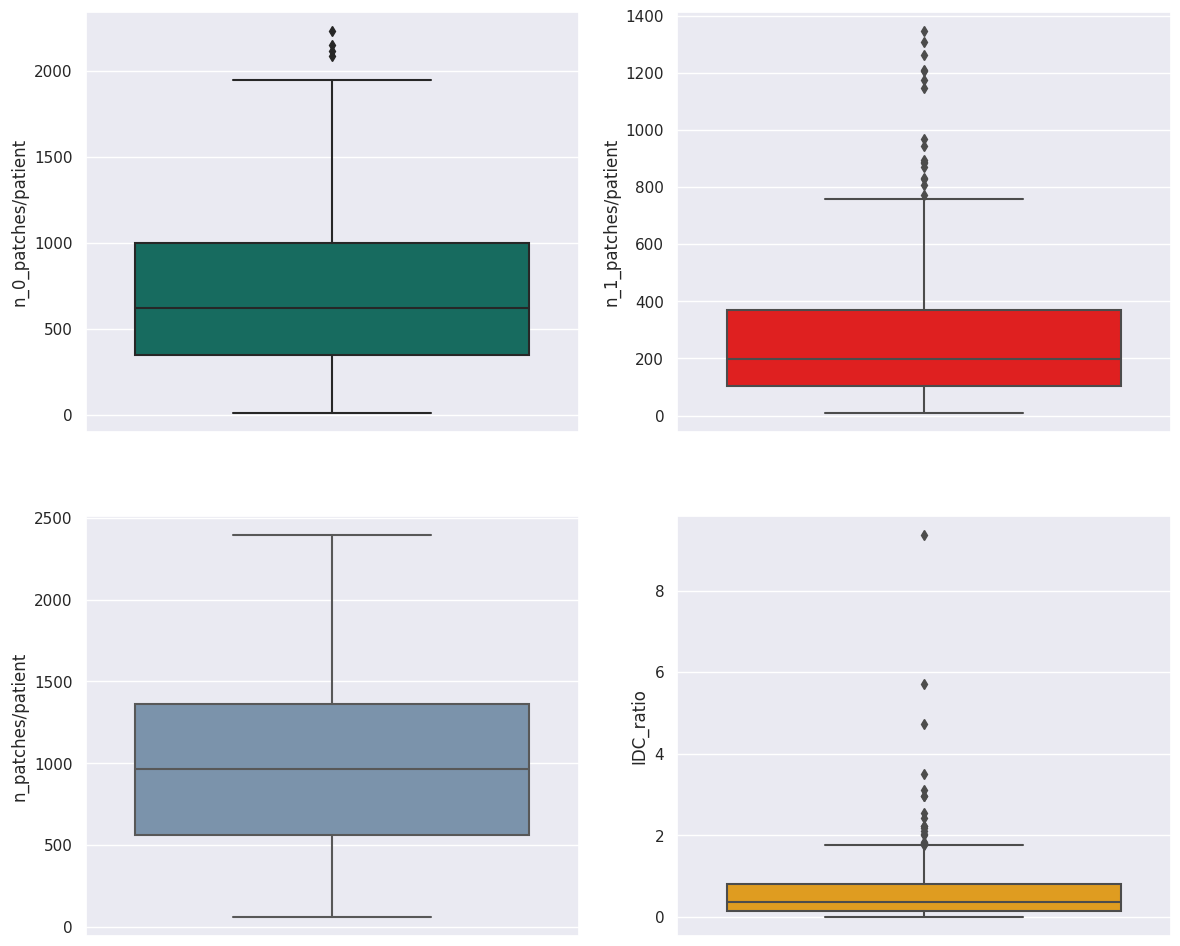

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.boxplot(y=data_summary["n_0_patches/patient"], orient = "h", ax=axes[0,0], color='#097969')
sns.boxplot(y=data_summary["n_1_patches/patient"], orient = "h", ax=axes[0,1], color='red')
sns.boxplot(y=data_summary["n_patches/patient"], orient = "h", ax=axes[1,0], color='#7393B3')
sns.boxplot(y=data_summary["IDC_ratio"], orient = "h", ax=axes[1,1], color='orange')

The number of negative IDC patches, for the vast majority of the patients, tends to be inside the range of 347 - 998 patches. Also there is a small number of patients that have more than 2,000 patches per patient. In addition, the positive IDC patches for the majority of the patients tend to be between the range of 104 and 369. Once again we have some outliers with the patients that their number of patches is over 750 and the maximum number of positive patches is 1347 for one patient.
Figure 3 visualises the box plot of the total number of patches of all patients and the ratio of positive patches to negative patches (cancer ratio). The majority of patients have cancer ratio in the range of 0.16 (positive / negative patches) to 0.8. There are many patients that have cancer ratio that is higher than 1.75. The maximum cancer ratio is 9.36.


Visualise the patients that have negative patches

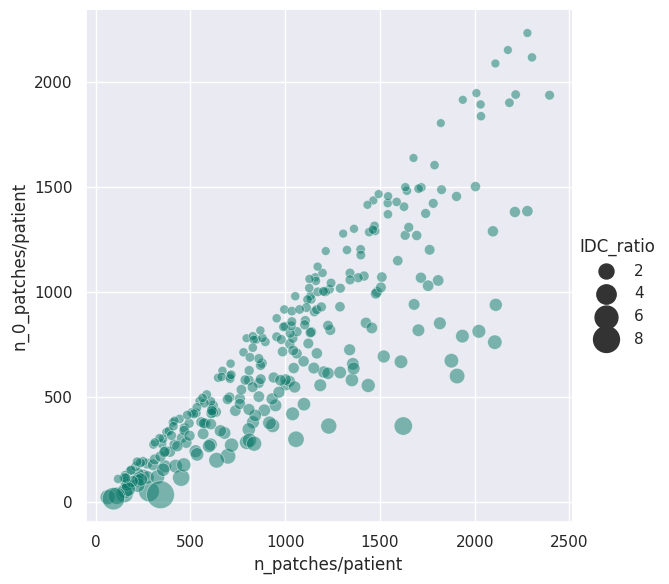

In [ ]:
sns.relplot(x="n_patches/patient", y="n_0_patches/patient", ax=ax1, size="IDC_ratio",
            sizes=(40, 400), alpha=.5, color='#097969',
            height=6, data=data_summary)

 In the above figure, each point shows the total number of patches of each patient in the x axis and the number of **negative** patches for the patient in the y axis. The diameter of each point corresponds to the IDC ratio of that patient. From this graph we can observe that most of the points with larger IDC ratio (bigger diameter) are concentrated at the beginning of the graph (between the range 0-500 for x axis and 0-1,000 y axis). This means that the majority of patients have a small number of positive patches (and proportionally small total number of patches). In addition the majority of patients have a large IDC ratio and also their number of negative patches is below 1,000.

Visualise the patients that have positive patches

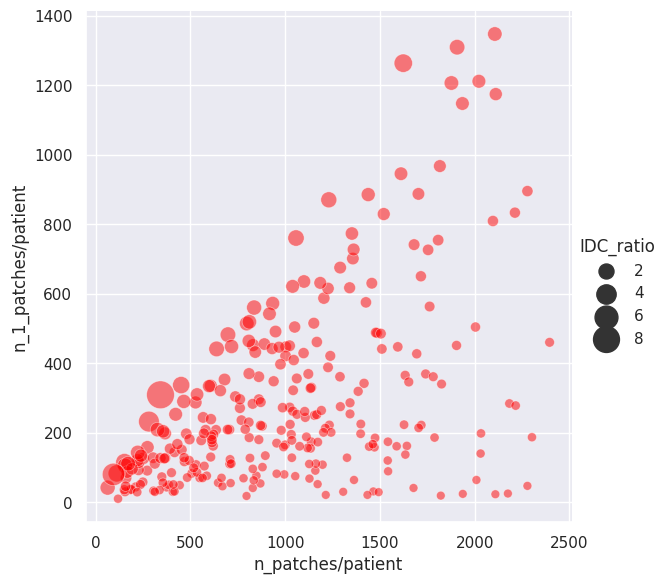

In [ ]:
sns.relplot(x="n_patches/patient", y="n_1_patches/patient",  ax=axes[1], size="IDC_ratio",
            sizes=(40, 400), alpha=.5, color='red',
            height=6, data=data_summary)

In the above figure, each point shows the total number of patches of each patient in the x axis and the number of **positive** patches for the patient in the y axis. The diameter of each point corresponds to the IDC ratio of that patient. Most of the points with larger IDC ratio (bigger diameter) are concentrated at the beginning of the graph (between the range 0-1,000 for x axis and 0-600 y axis). This means that the majority of patients have a small number of positive patches (and proportionally small total number of patches). Although, the majority of patients that have a large IDC ratio have a number of positive patches below 1,000, there are some patients with  high IDC ratio that have postitive number of patches above 1150.

Visualise the IDC ratio for all patients and their total number of patches.

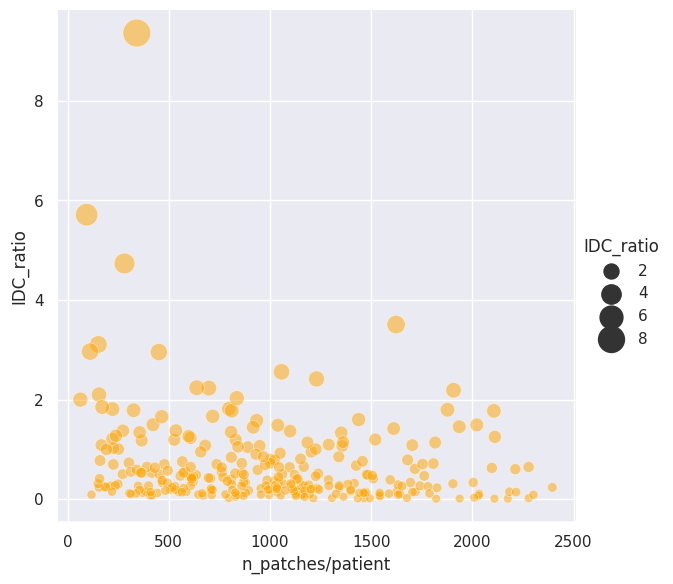

In [ ]:
sns.relplot(x="n_patches/patient", y="IDC_ratio",  size="IDC_ratio",
            sizes=(40, 400), alpha=.5, color='orange',
            height=6, data=data_summary)

The majority of patients fave an IDC ration below 2 but there are also some patients having IDC ration above 4.

Visualise the IDC ratio for all patients and their total number of patches with an **interactive** mode

In [ ]:
import plotly.express as px

fig = px.scatter(data_summary, x="n_patches/patient", y="IDC_ratio",
                 size='IDC_ratio', hover_data=['IDC_ratio'])
fig.show()
fig.write_html("/content/drive/MyDrive/IDC assignment/breastcancermodel/chart.html")

**Please open `chart.html` file**

Produce summarized data to contain for each patient the number of positive/negative patches (i.e. view data_summary from wide to long format)

In [ ]:
data_long = data.groupby(['patient_id', 'target']).size().unstack(fill_value=1)
data_long = data_long.reset_index()
data_long = pd.melt(data_long, id_vars='patient_id', value_vars=['0', '1'])
data_long.columns = ['patient_id', 'target', 'no_of_patches']
data_long.shape

(558, 3)

In [ ]:
data_long.head()

patient_id target  no_of_patches
0        8863      0            772
1        8864      0            805
2        8865      0            657
3        8867      0           1480
4        8913      0            873

Visualize per each patient, the number of positive and negative patches

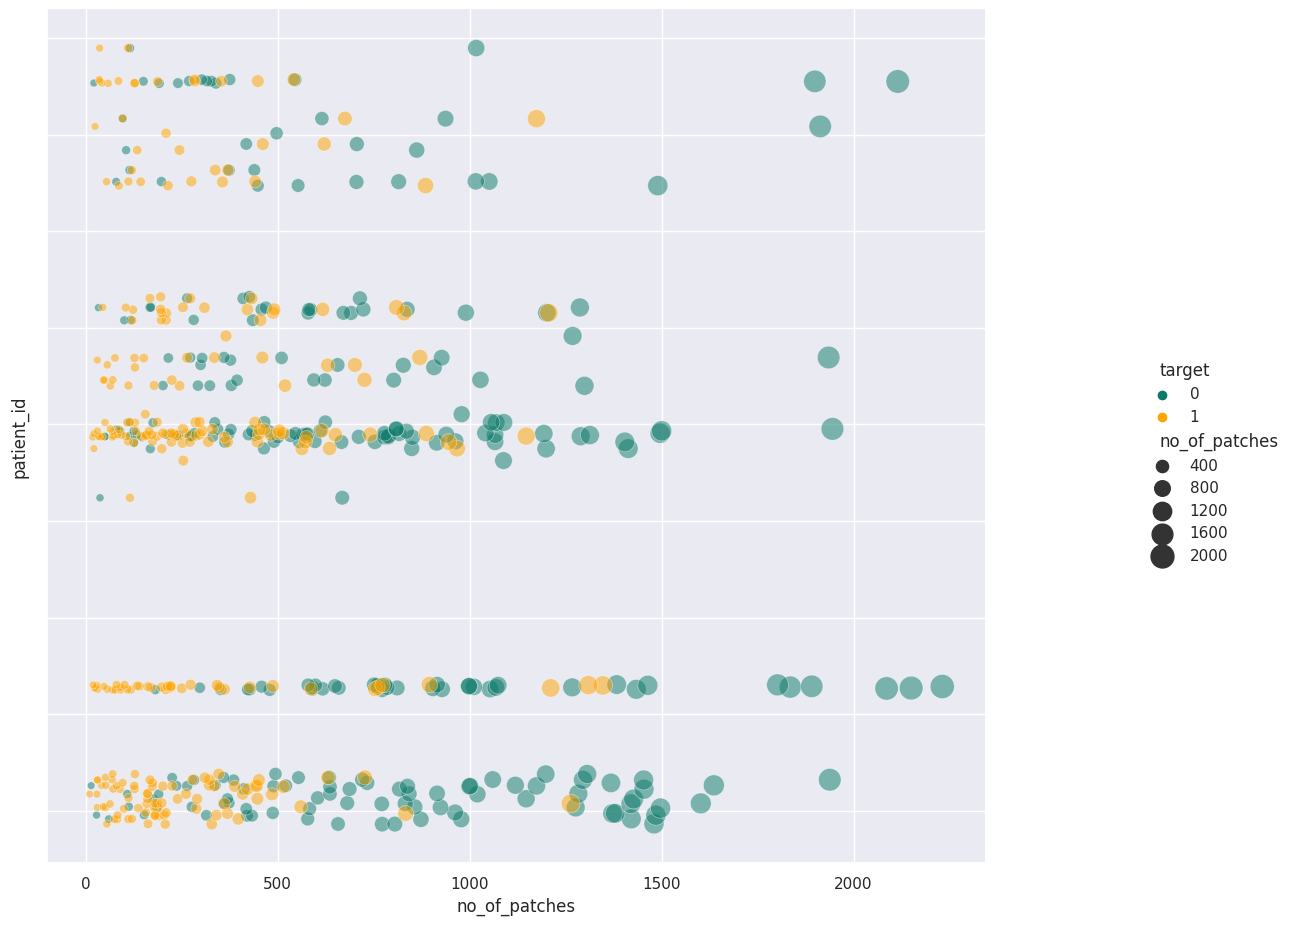

In [ ]:
#
p1 = sns.relplot(x="no_of_patches", y="patient_id", hue="target", size="no_of_patches",
            sizes=(30, 300), alpha=.5, palette=["#097969", "orange"],
            height=6, data=data_long)
p1.fig.set_size_inches(15,10)
p1.set(yticklabels=[])

The above figure visualises the number of patches per each patient (the number of negative patches with green colour and the number of positive patches having orange colour). The size of the points visualise the number of patches. We observed that the majority of the green points have larger count numbers.

Visualize the histogram of the number of patches per patient and the histogram of the percentage of an image coved by IDC.

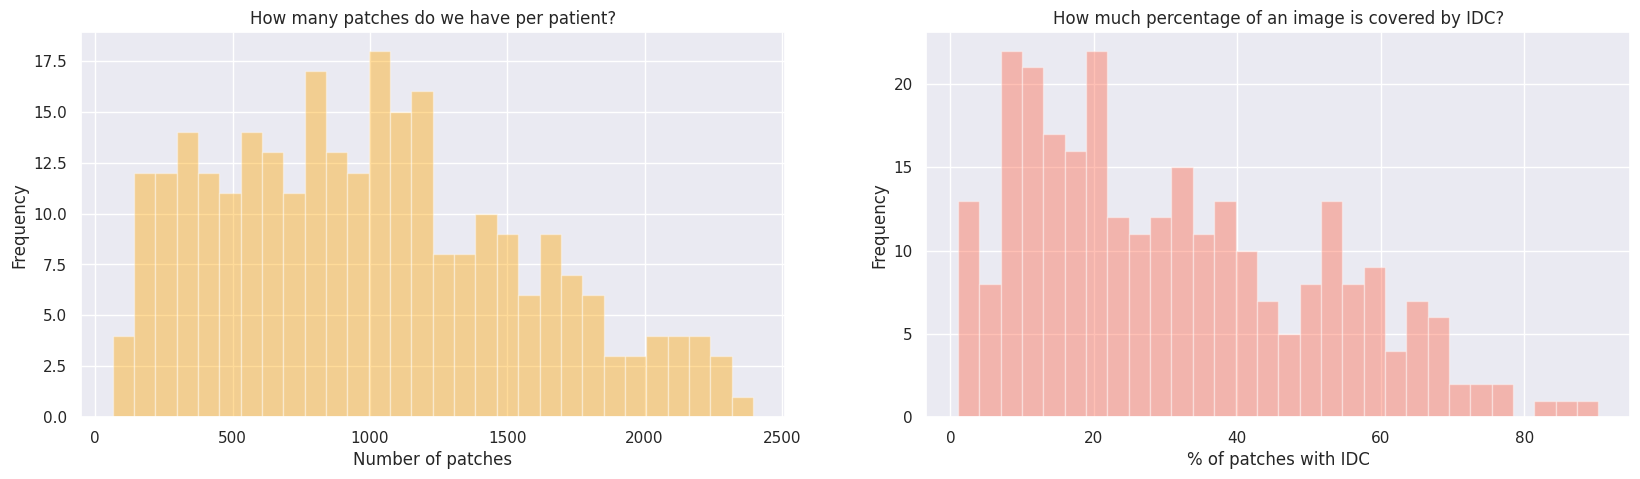

In [ ]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");


Text(0.5, 1.0, 'Target Distribution')

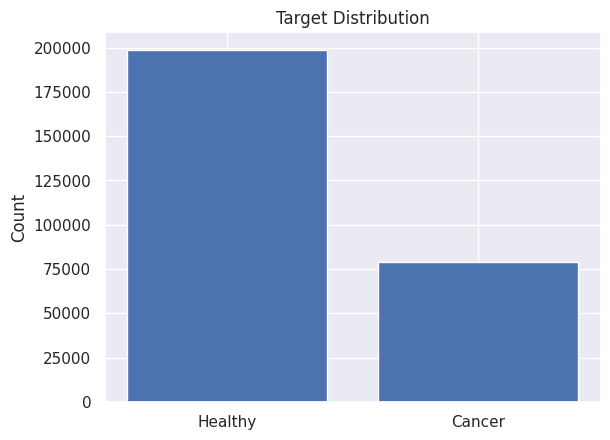

In [ ]:
target_vals = data['target'].value_counts().index.values
target_vals = target_vals.astype(str).tolist()
plt.bar(target_vals, data['target'].value_counts(), tick_label =['Healthy', 'Cancer'] )
plt.ylabel('Count')
plt.title('Target Distribution')

### Insights

1. The number of image patches per patient varies a lot.
2. Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer.
3. The **classes of IDC versus no IDC are imbalanced**. We have to check this again after setting up a validation strategy and find a strategy to deal with class weights.

## Looking at healthy and cancer patches <a class="anchor" id="patches"></a>

In [ ]:
data.target = data.target.astype(np.int)

In [ ]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

### Cancer patches

In [ ]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Healthy patches

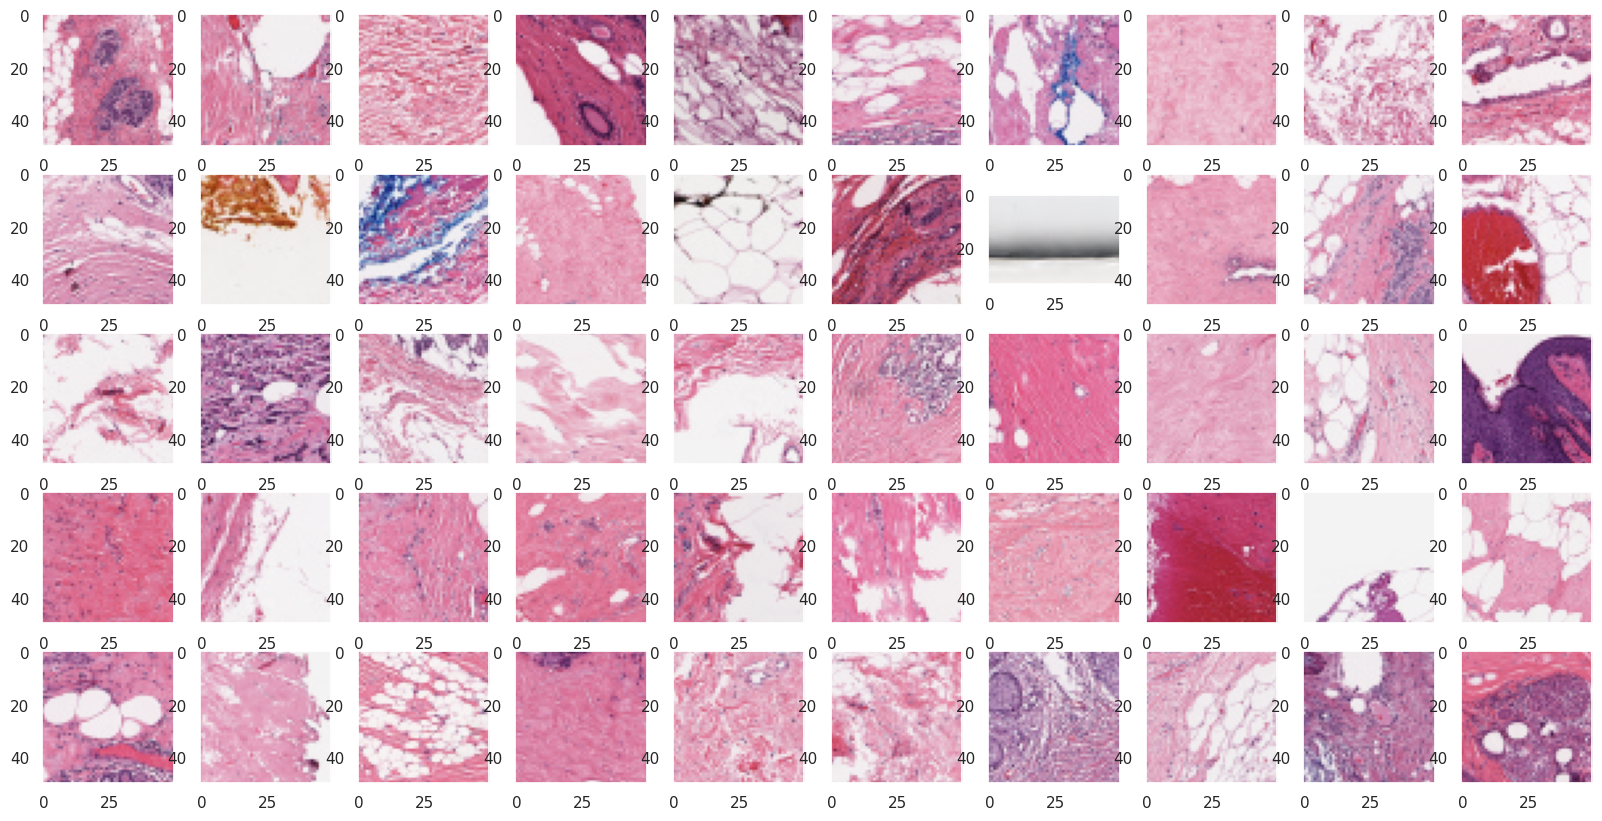

In [ ]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [ ]:
#helper functions
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

# Setting up the machine learning workflow <a class="anchor" id="workflow"></a>

## Settings <a class="anchor" id="ml_settings"></a>

In [ ]:
NUM_CLASSES = 2

OUTPUT_PATH = "/content/drive/MyDrive/IDC assignment/breastcancermodel/"
MODEL_PATH = "/content/drive/MyDrive/IDC assignment/breastcancermodel/"
LOSSES_PATH = "/content/drive/MyDrive/IDC assignment/breastcancermodel/"

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

## Validation strategy <a class="anchor" id="validation"></a>

Let's start very simple by selecting 30 % of the patients as test data and the remaining 70 % for training and developing.

In [ ]:
data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 8.5+ MB


In [ ]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

In [ ]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 15.053763440860216 15.053763440860216


Now it's 70 % train and 15 % for dev and test.

In [ ]:
print(len(train_ids), len(dev_ids), len(test_ids))

195 42 42


In [ ]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

## Target distributions <a class="anchor" id="target_dists"></a>

Text(0.5, 1.0, 'Target Distribution Train Set')

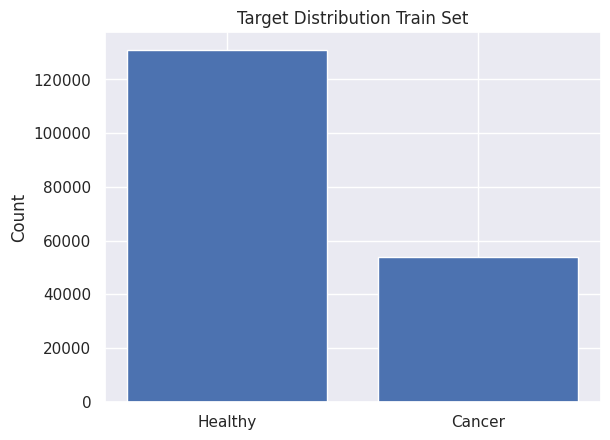

In [ ]:
target_vals = train_df.target.value_counts().index.values
target_vals = target_vals.astype(str).tolist()
plt.bar(target_vals, train_df.target.value_counts() , tick_label =['Healthy', 'Cancer'] )
plt.ylabel('Count')
plt.title('Target Distribution Train Set')

Text(0.5, 1.0, 'Target Distribution Development Set')

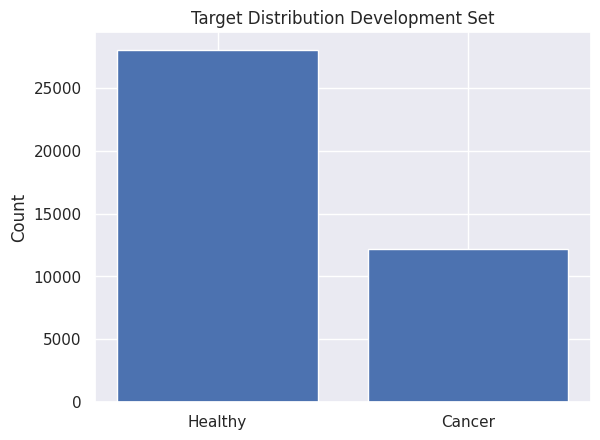

In [ ]:
target_vals = dev_df.target.value_counts().index.values
target_vals = target_vals.astype(str).tolist()
plt.bar(target_vals, dev_df.target.value_counts() , tick_label =['Healthy', 'Cancer'] )
plt.ylabel('Count')
plt.title('Target Distribution Development Set')

Text(0.5, 1.0, 'Target Distribution Test Set')

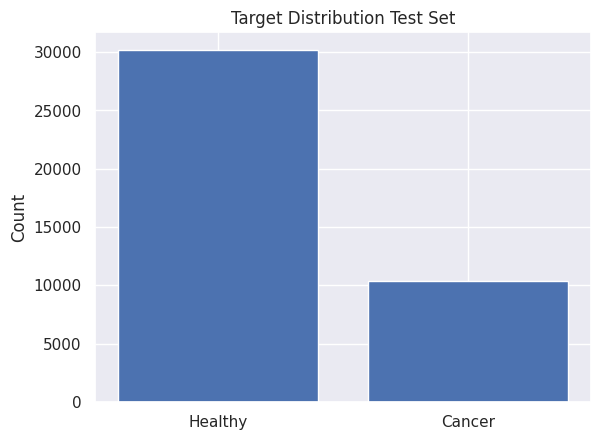

In [ ]:
target_vals = test_df.target.value_counts().index.values
target_vals = target_vals.astype(str).tolist()
plt.bar(target_vals, test_df.target.value_counts(), tick_label =['Healthy', 'Cancer'] )
plt.ylabel('Count')
plt.title('Target Distribution Test Set')

## Creating pytorch image datasets <a class="anchor" id="image_datasets"></a>

Define data transformations

In [ ]:
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((50,50)),
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.Resize((299, 299), antialias=True),  # Resize images to 299by299
                      transforms.RandomRotation(25), #rotate the image by 25 degrees
                      transforms.RandomAffine([0.11, 0.11])] #blur the edges
    val_sequence = [transforms.Resize((50,50))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

Create dataset: by loading an image patch of a patient, converting it to RGB, and augmentating it.

In [ ]:
class BreastCancerDataset(Dataset):

    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        if "target" in self.states.columns.values:
            target = np.int(self.states.target.values[idx])
        else:
            target = None

        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [ ]:
train_dataset = BreastCancerDataset(train_df, transform=my_transform(key="train"))
dev_dataset = BreastCancerDataset(dev_df, transform=my_transform(key="val"))
test_dataset = BreastCancerDataset(test_df, transform=my_transform(key="val"))

In [ ]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

In [ ]:
train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

For validation only the image resizing transformation used.

We examined models on 3 differnt batch sizes, 16,32 and 64. These are split into sections here.

Batch Size = 16

In [ ]:
BATCH_SIZE = 16

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [ ]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

12275 2600 2469


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Use transfer learning with a pretrained CNN. 

Thus the first layers of a pretrained CNN extract basic features like edges for example and only last layers contain very problem specific features. 

Use a pretrained resent-18 model, removing final fully connected layer and adding in 3 linear layers with batch normalization and dropout of 0.2 after each layer.

In [ ]:
run_training=False
model = torchvision.models.resnet18(pretrained=True)
if run_training:
    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),

    nn.Linear(128, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


512


## Setting up the loss function <a class="anchor" id="loss"></a>

Use binary cross entropy loss function.

In [ ]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6978, 1.7641], device='cuda:0')


In [ ]:
train_df.target.unique()

array(['0', '1'], dtype=object)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

## Selecting an evaluation metric <a class="anchor" id="e_metric"></a>

Use The f1-score (harmonic mean of precision and recall)

In [ ]:
def f1_score(preds, targets):

    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)

    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

## Building the training loop <a class="anchor" id="train_loop"></a>

In [ ]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    early_trigger = 5 #if the validation AUC hasn't increased in five epochs, stop the training
    early_stop = 0 #counter for the number of iterations where there has been no increase in validation AUC
    early_stop_happend = False #flag to stop training
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)

    running_loss_dict = {"train": [], "dev": [], "test": []}

    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2

    for epoch in range(num_epochs):
        if early_stop_happend == True:
          break
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)

                        #loss += l2_reg

                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step()
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                counter += 1


                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))

            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' :
              if epoch_acc > best_acc:
                early_stop=0
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
              else:
                early_stop+= 1
              if early_stop == early_trigger:
                print('Early stopping after {} epochs'.format(epoch))
                early_stop_happend = True
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

## Searching for an optimal cyclical learning rate <a class="anchor" id="lr_cycle_optima"></a>

Refer to the paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).

In [ ]:
start_lr = 1e-6
end_lr = 0.1

In [ ]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular")

    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = np.int(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular")
    return scheduler

In [ ]:
find_learning_rate = False

In [ ]:
MODEL_PATH

'/content/drive/MyDrive/IDC assignment/breastcancermodel/'

In [ ]:
import math

if find_learning_rate:
    lr_find_epochs=1
    optimizer = optim.SGD(model.fc.parameters(), start_lr)
    scheduler = get_lr_search_scheduler(optimizer, start_lr, end_lr, lr_find_epochs*len(train_dataloader))
    results = train_loop(model, criterion, optimizer, lr_find=True, scheduler=scheduler, num_epochs=lr_find_epochs)
    lr_find_lr, lr_find_loss = results["lr_find"]["lr"], results["lr_find"]["loss"]

    find_lr_df = pd.DataFrame(lr_find_loss, columns=["smoothed loss"])
    find_lr_df.loc[:, "lr"] = lr_find_lr
    find_lr_df.to_csv(MODEL_PATH + "learning_rate_search.csv", index=False)
else:
    find_lr_df = pd.read_csv("/content/drive/MyDrive/IDC assignment/breastcancermodel/learning_rate_search.csv")

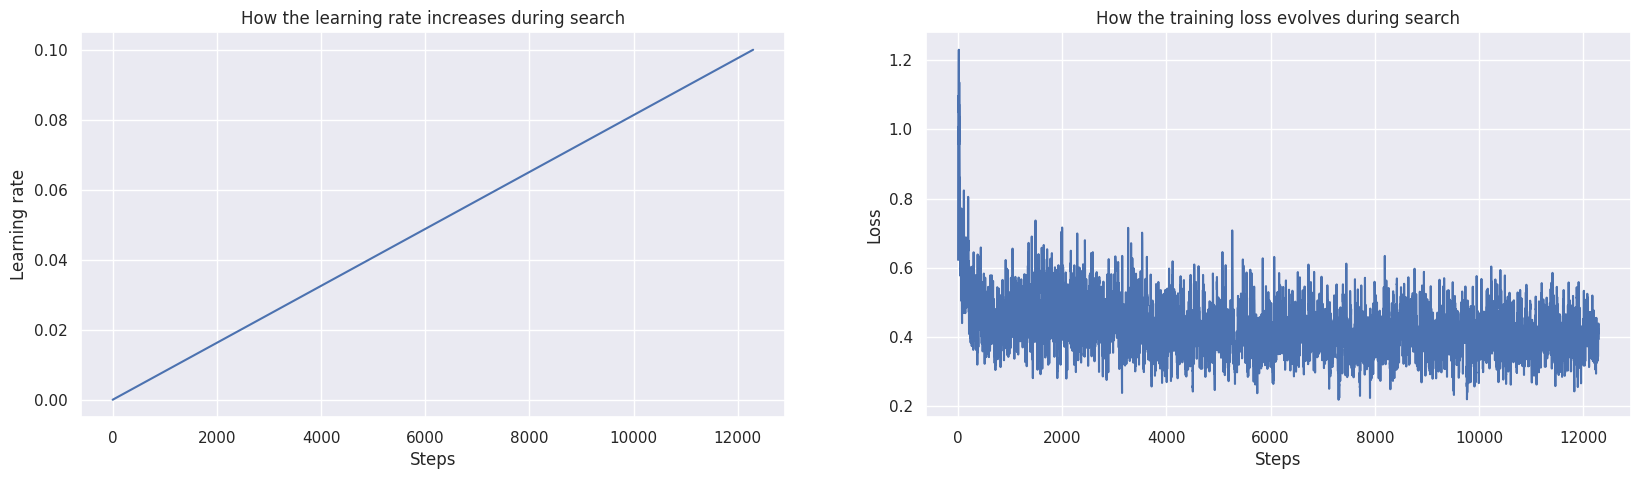

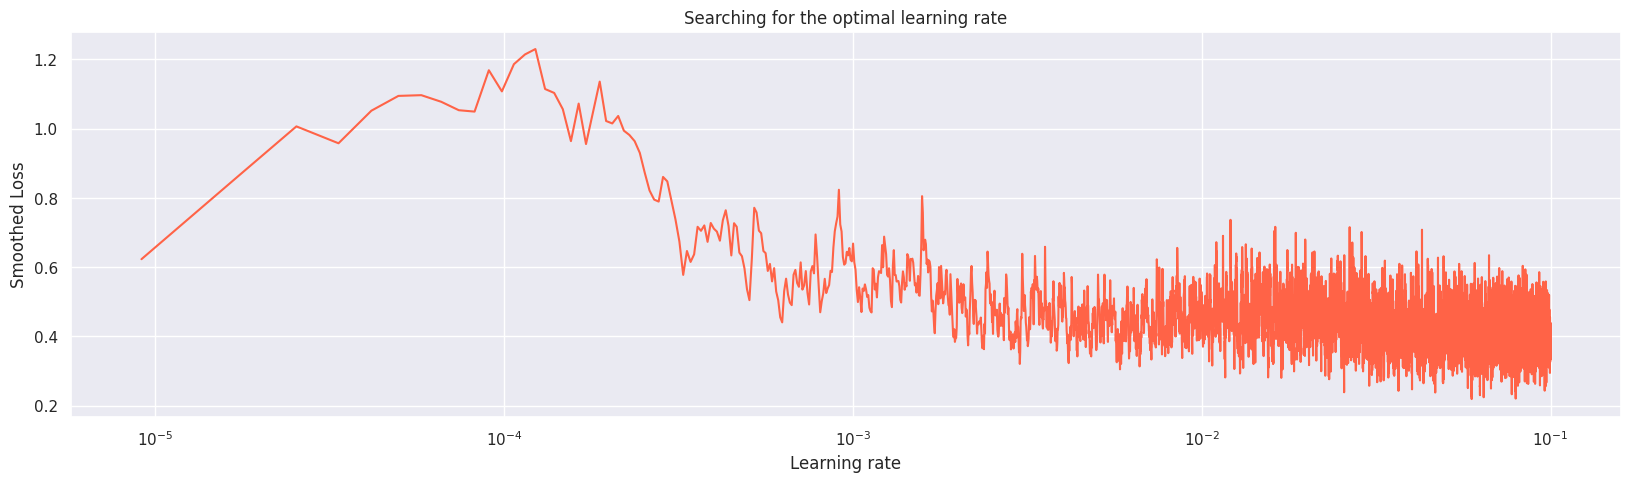

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(find_lr_df.lr.values)
ax[1].plot(find_lr_df["smoothed loss"].values)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Learning rate")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss");
ax[0].set_title("How the learning rate increases during search")
ax[1].set_title("How the training loss evolves during search")

plt.figure(figsize=(20,5))
plt.plot(find_lr_df.lr.values, find_lr_df["smoothed loss"].values, '-', color="tomato");
plt.xlabel("Learning rate")
plt.xscale("log")
plt.ylabel("Smoothed Loss")
plt.title("Searching for the optimal learning rate");

In [ ]:
start_lr = 1e-6
end_lr = 0.1

In [ ]:
run_training = True

In [ ]:
OUTPUT_PATH

'/content/drive/MyDrive/IDC assignment/breastcancermodel/'

In [ ]:
if run_training:
  NUM_EPOCHS = 30
  optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
  scheduler = get_scheduler(optimizer, start_lr, end_lr, NUM_EPOCHS)
  results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
  model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]

  if device == "cpu":
      OUTPUT_PATH += ".pth"
  else:
      OUTPUT_PATH += "_cuda.pth"

  torch.save(model.state_dict(), OUTPUT_PATH)

  losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
  losses_df.loc[:, "dev"] = loss_dict["dev"]
  losses_df.loc[:, "test"] = loss_dict["test"]
  losses_df.to_csv(MODEL_PATH +"losses_breastcancer.csv", index=False)

  running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
  running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
  running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
  running_losses_df.to_csv(MODEL_PATH +"running_losses_breastcancer.csv", index=False)
else:
    if device == "cpu":
        load_path = MODEL_PATH + ".pth"
    else:
        load_path = MODEL_PATH + "_cuda_batch_size_64.pth"
    model.load_state_dict(torch.load(load_path, map_location='cpu'))
    model.eval()

    losses_df = pd.read_csv(LOSSES_PATH + "losses_breastcancer.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_breastcancer.csv")

Epoch 0/29
----------


  0%|          | 0/12275 [00:00<?, ?it/s]

train Loss: 0.4127 Acc: 0.8245


  0%|          | 0/2600 [00:00<?, ?it/s]

dev Loss: 1.3745 Acc: 0.6879


  0%|          | 0/2469 [00:00<?, ?it/s]

test Loss: 1.3472 Acc: 0.6846

Epoch 1/29
----------


  0%|          | 0/12275 [00:00<?, ?it/s]

train Loss: 0.3860 Acc: 0.8348


  0%|          | 0/2600 [00:00<?, ?it/s]

dev Loss: 1.2606 Acc: 0.6833


  0%|          | 0/2469 [00:00<?, ?it/s]

test Loss: 1.2487 Acc: 0.6858

Epoch 2/29
----------


  0%|          | 0/12275 [00:00<?, ?it/s]

train Loss: 0.3810 Acc: 0.8375


  0%|          | 0/2600 [00:00<?, ?it/s]

dev Loss: 2.4638 Acc: 0.7142


  0%|          | 0/2469 [00:00<?, ?it/s]

test Loss: 2.7307 Acc: 0.6929

Epoch 3/29
----------


  0%|          | 0/12275 [00:00<?, ?it/s]

train Loss: 0.3764 Acc: 0.8389


  0%|          | 0/2600 [00:00<?, ?it/s]

dev Loss: 1.8051 Acc: 0.6469


  0%|          | 0/2469 [00:00<?, ?it/s]

test Loss: 1.7842 Acc: 0.6685

Epoch 4/29
----------


  0%|          | 0/12275 [00:00<?, ?it/s]

train Loss: 0.3731 Acc: 0.8414


  0%|          | 0/2600 [00:00<?, ?it/s]

dev Loss: 1.9610 Acc: 0.6893


  0%|          | 0/2469 [00:00<?, ?it/s]

test Loss: 1.9484 Acc: 0.6890

Epoch 5/29
----------


  0%|          | 0/12275 [00:00<?, ?it/s]

train Loss: 0.3686 Acc: 0.8440


  0%|          | 0/2600 [00:00<?, ?it/s]

dev Loss: 2.6016 Acc: 0.6956


  0%|          | 0/2469 [00:00<?, ?it/s]

test Loss: 2.1192 Acc: 0.6968

Epoch 6/29
----------


  0%|          | 0/12275 [00:00<?, ?it/s]

train Loss: 0.3685 Acc: 0.8439


  0%|          | 0/2600 [00:00<?, ?it/s]

dev Loss: 3.2096 Acc: 0.6219


  0%|          | 0/2469 [00:00<?, ?it/s]

test Loss: 2.9365 Acc: 0.5971

Epoch 7/29
----------


  0%|          | 0/12275 [00:00<?, ?it/s]

train Loss: 0.3673 Acc: 0.8447


  0%|          | 0/2600 [00:00<?, ?it/s]

dev Loss: 2.3181 Acc: 0.6968
Early stopping after 7 epochs


  0%|          | 0/2469 [00:00<?, ?it/s]

test Loss: 2.3122 Acc: 0.6853

Training complete in 124m 21s
Best val Acc: 0.714162


# Exploring results and errors <a class="anchor" id="error_analysis"></a>

## Loss convergence <a class="anchor" id="losses"></a>

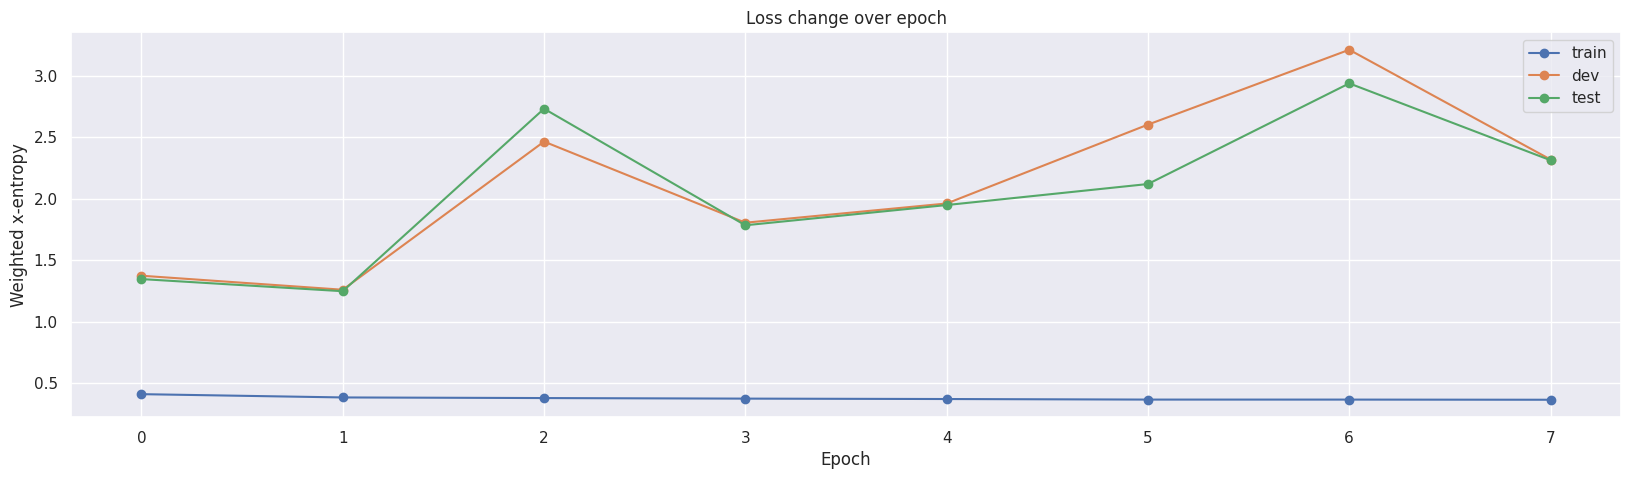

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(losses_df["train"], '-o', label="train")
plt.plot(losses_df["dev"], '-o', label="dev")
plt.plot(losses_df["test"], '-o', label="test")
plt.xlabel("Epoch")
plt.ylabel("Weighted x-entropy")
plt.title("Loss change over epoch")
plt.legend();

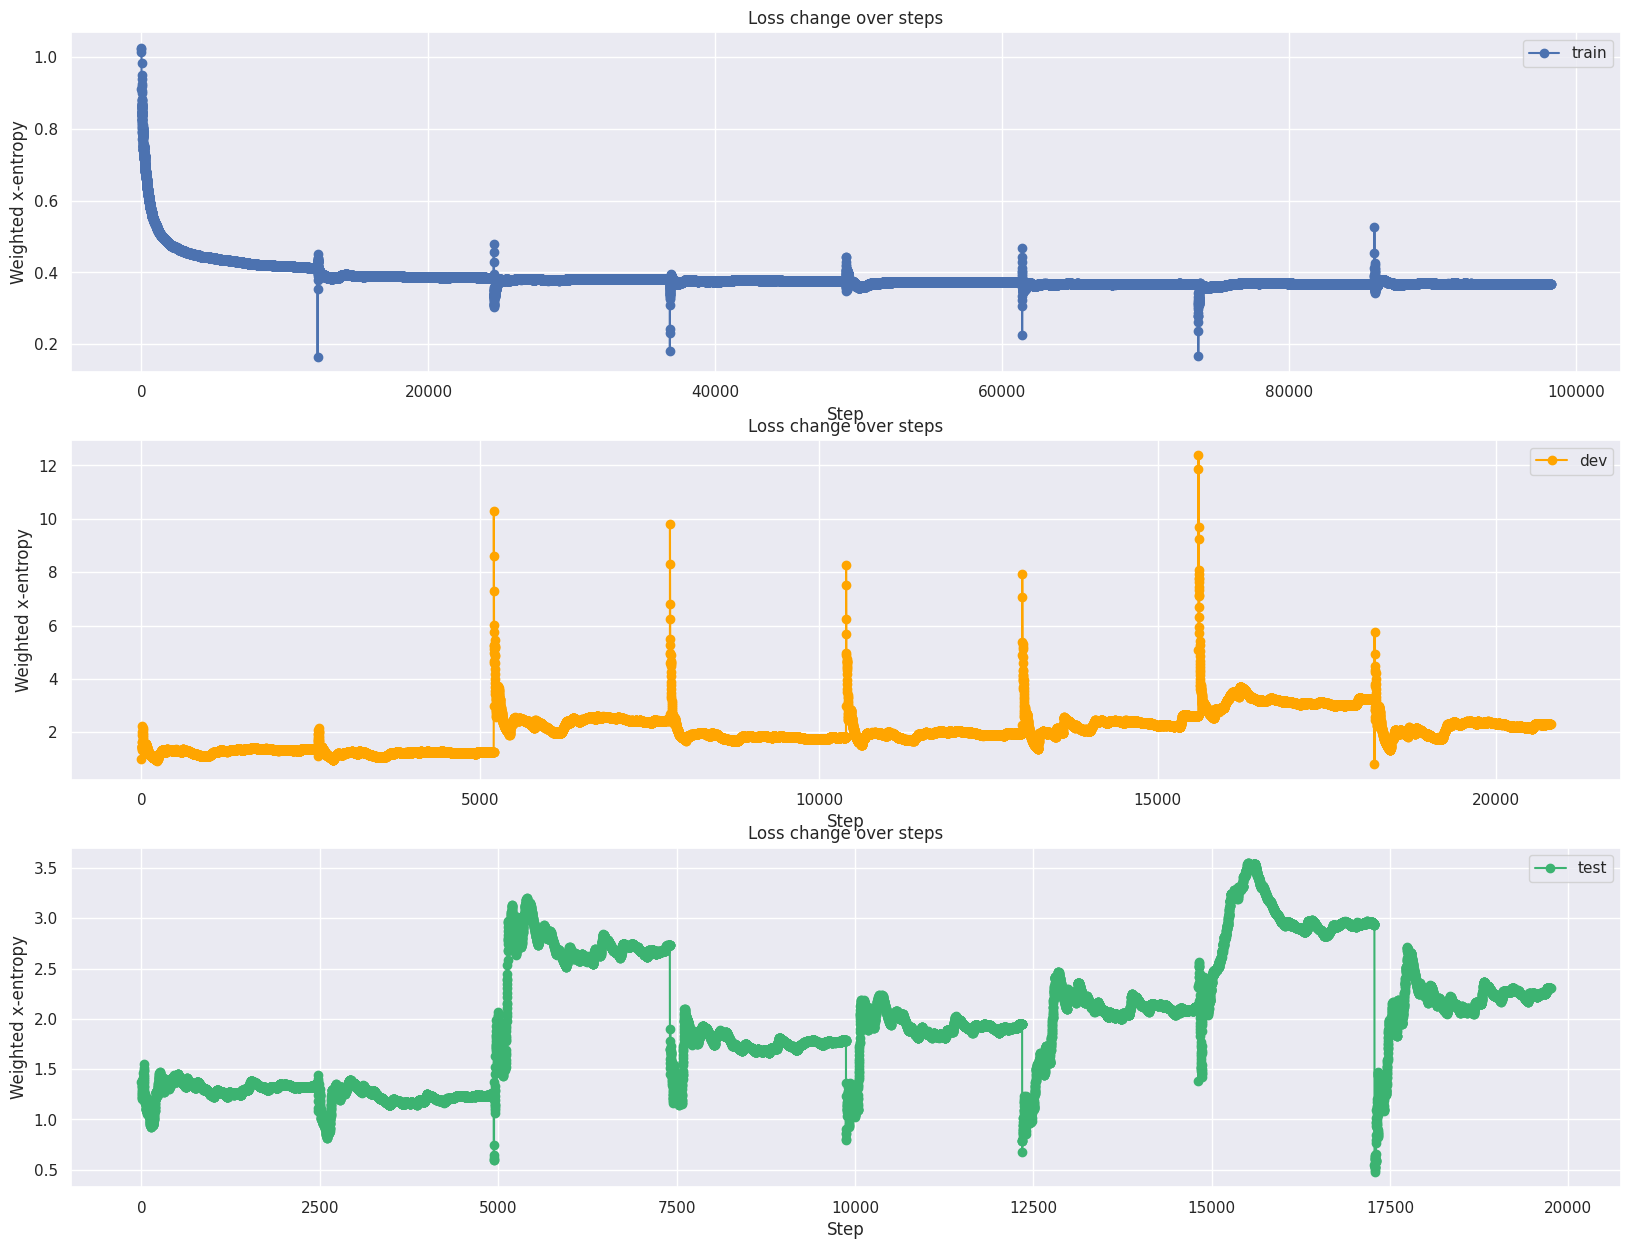

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,15))

ax[0].plot(running_losses_df["train"], '-o', label="train")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Weighted x-entropy")
ax[0].set_title("Loss change over steps")
ax[0].legend();

ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Weighted x-entropy")
ax[1].set_title("Loss change over steps")
ax[1].legend();

ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Weighted x-entropy")
ax[2].set_title("Loss change over steps")
ax[2].legend();

In [ ]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            proba = outputs.cpu().numpy().astype(np.float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]

    predictions_df = predictions_df.dropna()
    return predictions_df

In [ ]:
run_training = True

In [ ]:
if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")

    dev_filename = LOSSES_PATH + "dev_predictions.csv"
    test_filename = LOSSES_PATH + "test_predictions.csv"
    dev_predictions.to_csv(dev_filename, index=False)
    test_predictions.to_csv(test_filename, index=False)

else:

    dev_predictions = pd.read_csv(LOSSES_PATH + "dev_predictions.csv")
    test_predictions = pd.read_csv(LOSSES_PATH + "test_predictions.csv")

    dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

In [ ]:
dev_predictions

true predicted     proba       x       y patient_id
0        0         1  0.586633   951.0   451.0      16531
1        0         0   0.02718   651.0   251.0      16531
2        0         0  0.006373   451.0   751.0      16531
3        0         1  0.999252   901.0  1101.0      16531
4        0         0  0.308977   801.0   251.0      16531
...    ...       ...       ...     ...     ...        ...
41595    1         0  0.019858  1301.0  1701.0      12868
41596    1         1  0.857116  1501.0  1151.0      12868
41597    1         0   0.46967  1451.0  1201.0      12868
41598    1         0  0.000067  1451.0  2051.0      12868
41599    1         0  0.057534  1401.0  2201.0      12868

[41600 rows x 6 columns]

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "cancer", 0: "no cancer"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])

    labels = ["no cancer", "cancer"]
    index_labels = ["actual no cancer", "actual cancer"]
    col_labels = ["predicted no cancer", "predicted cancer"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

In [ ]:
confusion_df = get_confusion_matrix(dev_predictions['true'], dev_predictions['predicted'])
confusion_df.head()

predicted no cancer  predicted cancer
actual no cancer             0.875671          0.124329
actual cancer                0.732421          0.267579

In [ ]:
confusion_df = get_confusion_matrix(test_predictions['true'], test_predictions['predicted'])
confusion_df.head()

predicted no cancer  predicted cancer
actual no cancer             0.871628          0.128372
actual cancer                0.713339          0.286661

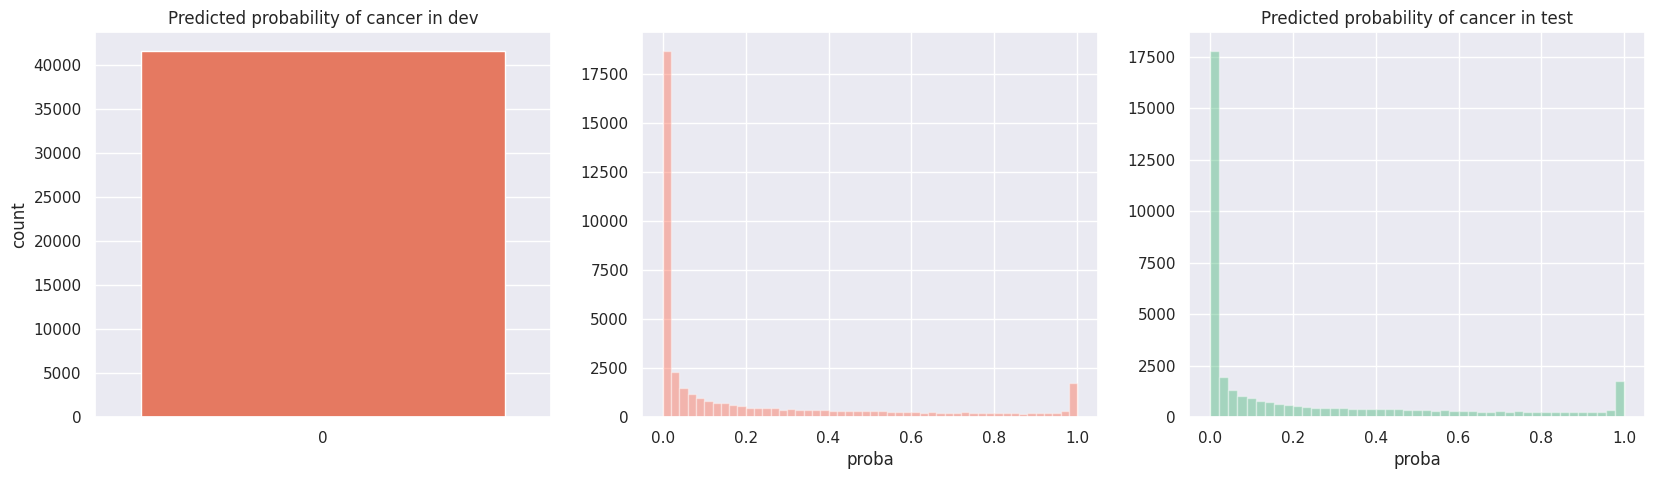

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(dev_predictions.true.astype(np.float), ax=ax[0], palette="Reds_r")
ax[0].set_title("Target counts of dev data");
sns.distplot(dev_predictions.proba.astype(np.float), ax=ax[1], kde=False, color="tomato")
ax[0].set_title("Predicted probability of cancer in dev");
sns.distplot(test_predictions.proba.astype(np.float), ax=ax[2], kde=False, color="mediumseagreen");
ax[2].set_title("Predicted probability of cancer in test");

Batch Size = 32

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [ ]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

6137 1300 1235


## Defining the model structure <a class="anchor" id="model_structure"></a>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
run_training=False
model = torchvision.models.resnet18(pretrained=True)
if run_training:
    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),

    nn.Linear(128, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


In [ ]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6978, 1.7641], device='cuda:0')


In [ ]:
train_df.target.unique()

array(['0', '1'], dtype=object)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
def f1_score(preds, targets):

    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)

    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

## Building the training loop <a class="anchor" id="train_loop"></a>

In [ ]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    early_trigger = 5 #if the validation AUC hasn't increased in five epochs, stop the training
    early_stop = 0 #counter for the number of iterations where there has been no increase in validation AUC
    early_stop_happend = False #flag to stop training
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)

    running_loss_dict = {"train": [], "dev": [], "test": []}

    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2

    for epoch in range(num_epochs):
        if early_stop_happend == True:
          break
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)

                        #loss += l2_reg

                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step()
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                counter += 1


                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))

            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' :
              if epoch_acc > best_acc:
                early_stop=0
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
              else:
                early_stop+= 1
              if early_stop == early_trigger:
                print('Early stopping after {} epochs'.format(epoch))
                early_stop_happend = True
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

## Searching for an optimal cyclical learning rate <a class="anchor" id="lr_cycle_optima"></a>



In [ ]:
start_lr = 1e-6
end_lr = 0.1

In [ ]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular")

    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = np.int(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular")
    return scheduler

In [ ]:
find_learning_rate = True

In [ ]:
MODEL_PATH

'/content/drive/MyDrive/IDC assignment/breastcancermodel/'

In [ ]:
import math

if find_learning_rate:
    lr_find_epochs=1
    optimizer = optim.SGD(model.fc.parameters(), start_lr)
    scheduler = get_lr_search_scheduler(optimizer, start_lr, end_lr, lr_find_epochs*len(train_dataloader))
    results = train_loop(model, criterion, optimizer, lr_find=True, scheduler=scheduler, num_epochs=lr_find_epochs)
    lr_find_lr, lr_find_loss = results["lr_find"]["lr"], results["lr_find"]["loss"]

    find_lr_df = pd.DataFrame(lr_find_loss, columns=["smoothed loss"])
    find_lr_df.loc[:, "lr"] = lr_find_lr
    find_lr_df.to_csv(MODEL_PATH + "learning_rate_search.csv", index=False)
else:
    find_lr_df = pd.read_csv(MODEL_PATH + "learning_rate_search.csv")

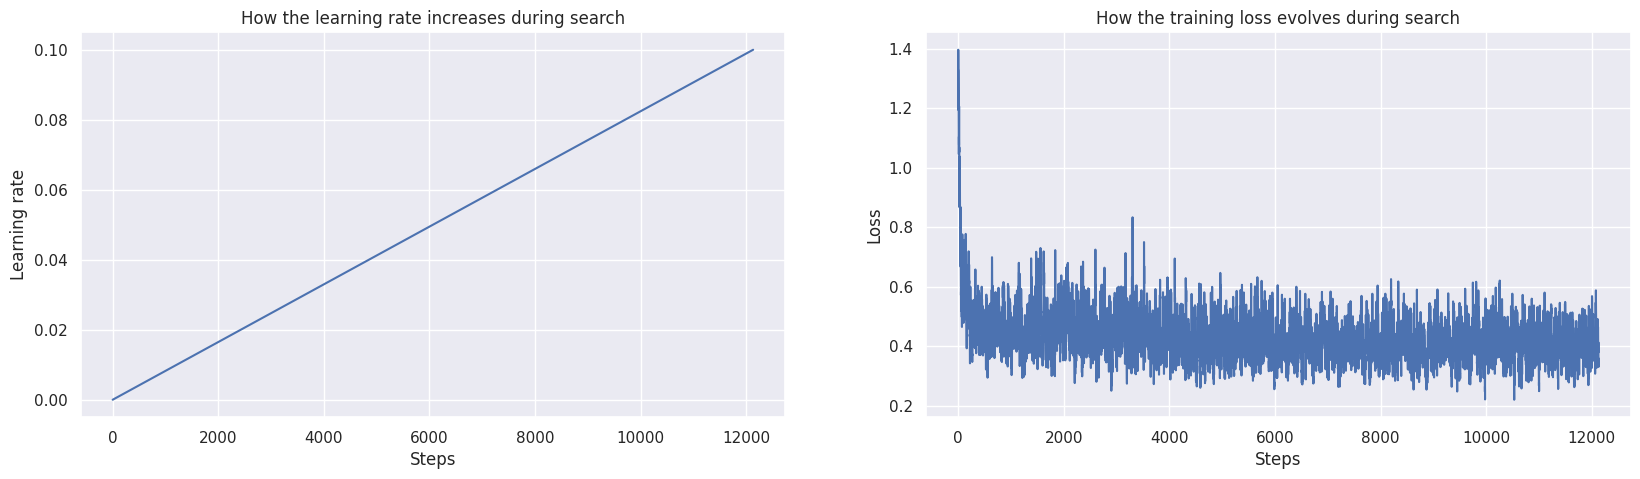

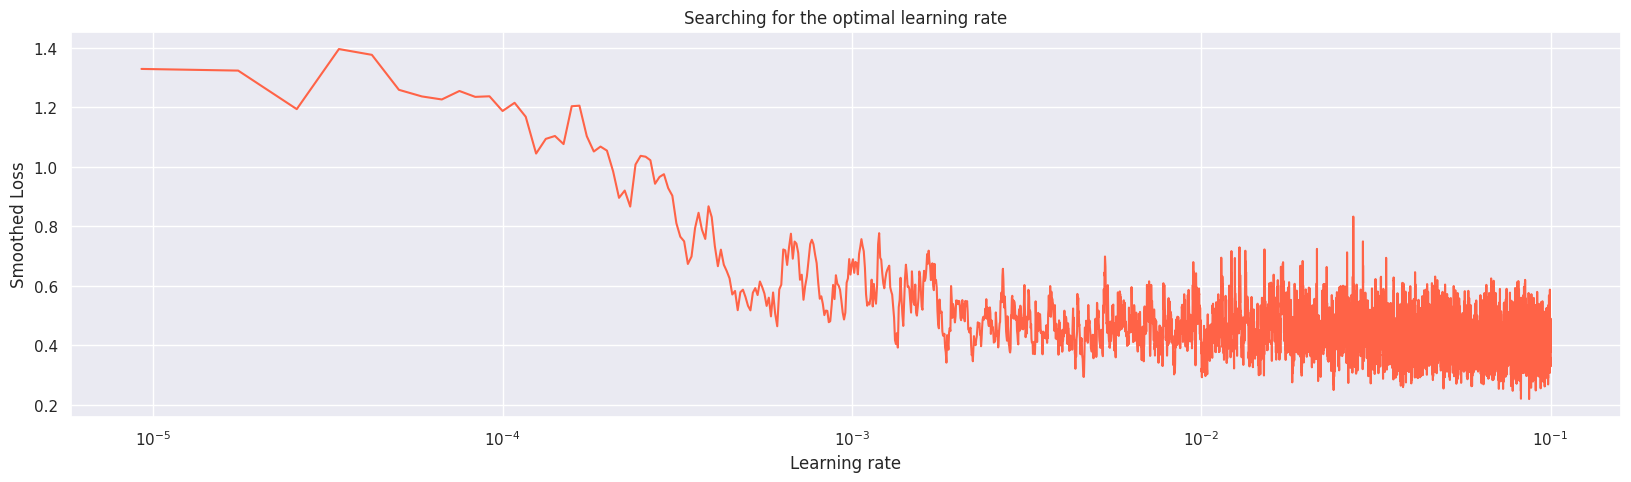

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(find_lr_df.lr.values)
ax[1].plot(find_lr_df["smoothed loss"].values)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Learning rate")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss");
ax[0].set_title("How the learning rate increases during search")
ax[1].set_title("How the training loss evolves during search")

plt.figure(figsize=(20,5))
plt.plot(find_lr_df.lr.values, find_lr_df["smoothed loss"].values, '-', color="tomato");
plt.xlabel("Learning rate")
plt.xscale("log")
plt.ylabel("Smoothed Loss")
plt.title("Searching for the optimal learning rate");

In [ ]:
start_lr = 1e-6
end_lr = 0.1

In [ ]:
run_training = True

In [ ]:
OUTPUT_PATH

'/content/drive/MyDrive/IDC assignment/breastcancermodel/'

In [ ]:
if run_training:
  NUM_EPOCHS = 30
  optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
  scheduler = get_scheduler(optimizer, start_lr, end_lr, NUM_EPOCHS)
  results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
  model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]

  if device == "cpu":
      OUTPUT_PATH += "_batch_size_32.pth"
  else:
      OUTPUT_PATH += "_cuda_batch_size_32.pth"

  torch.save(model.state_dict(), OUTPUT_PATH)

  losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
  losses_df.loc[:, "dev"] = loss_dict["dev"]
  losses_df.loc[:, "test"] = loss_dict["test"]
  losses_df.to_csv(MODEL_PATH +"losses_breastcancer_batch_size_32.csv", index=False)

  running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
  running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
  running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
  running_losses_df.to_csv(MODEL_PATH +"running_losses_breastcancer_batch_size_32.csv", index=False)
else:
    if device == "cpu":
        load_path = MODEL_PATH + "_batch_size_32.pth"
    else:
        load_path = MODEL_PATH + "_cuda_batch_size_32.pth"
    model.load_state_dict(torch.load(load_path, map_location='cpu'))
    model.eval()

    losses_df = pd.read_csv(LOSSES_PATH + "losses_breastcancert_batch_size_32.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_breastcancert_batch_size_32.csv")

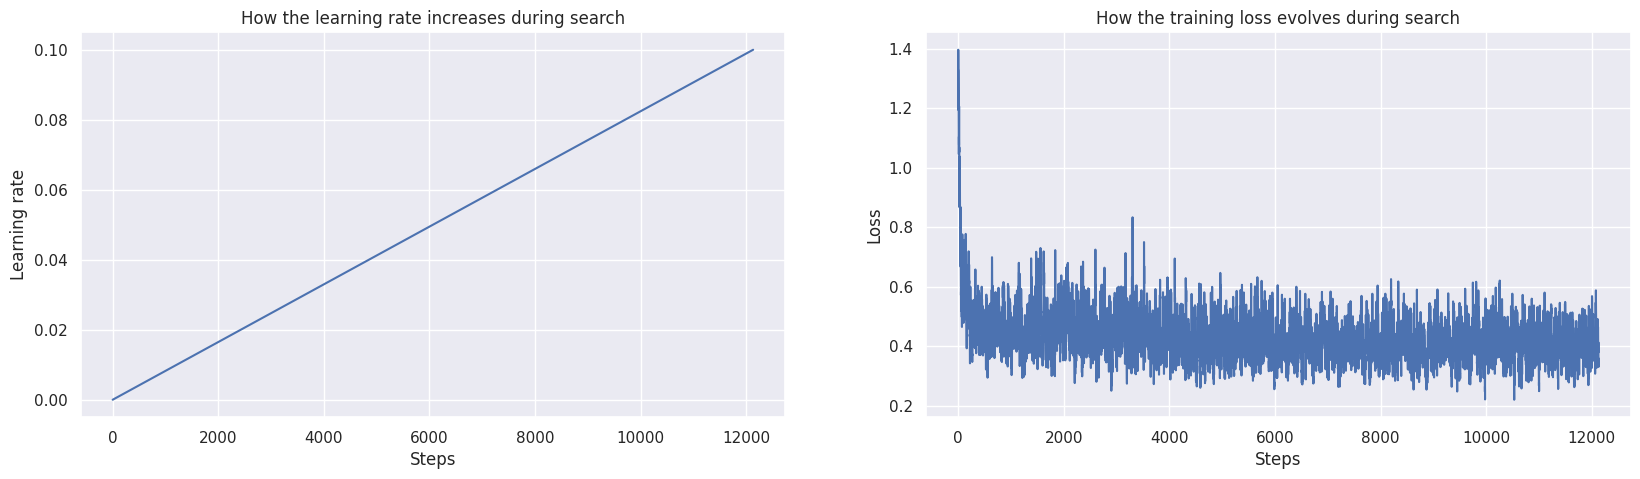

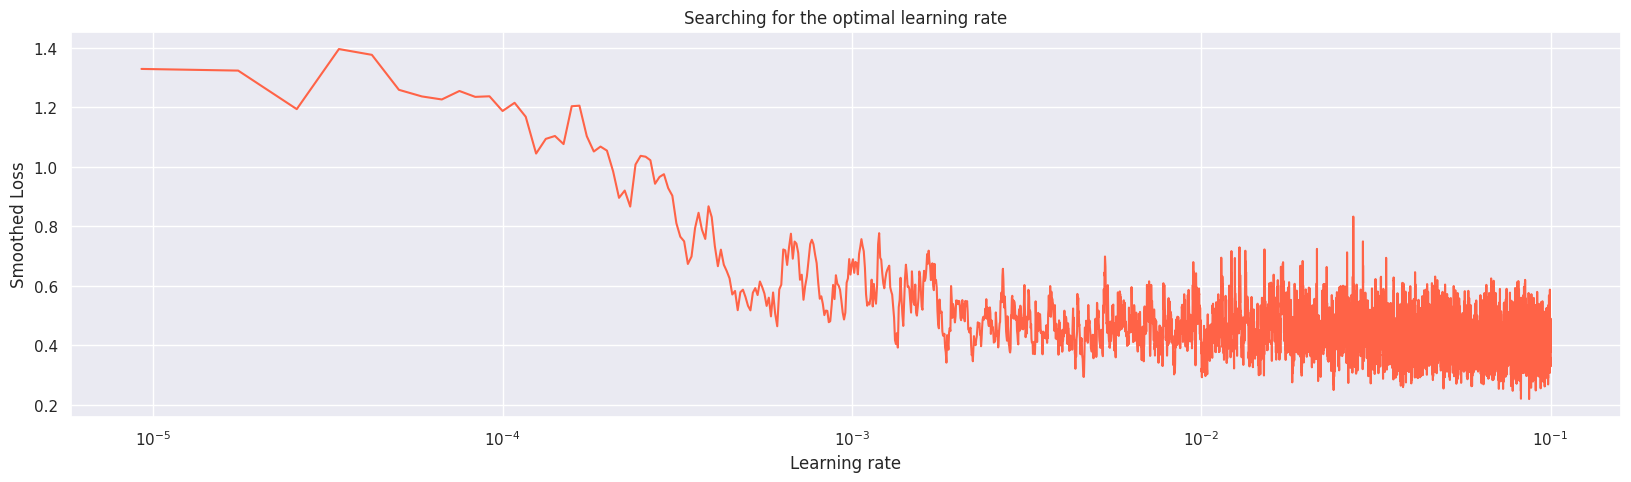

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(find_lr_df.lr.values)
ax[1].plot(find_lr_df["smoothed loss"].values)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Learning rate")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss");
ax[0].set_title("How the learning rate increases during search")
ax[1].set_title("How the training loss evolves during search")

plt.figure(figsize=(20,5))
plt.plot(find_lr_df.lr.values, find_lr_df["smoothed loss"].values, '-', color="tomato");
plt.xlabel("Learning rate")
plt.xscale("log")
plt.ylabel("Smoothed Loss")
plt.title("Searching for the optimal learning rate");

# Exploring results and errors <a class="anchor" id="error_analysis"></a>

## Loss convergence <a class="anchor" id="losses"></a>

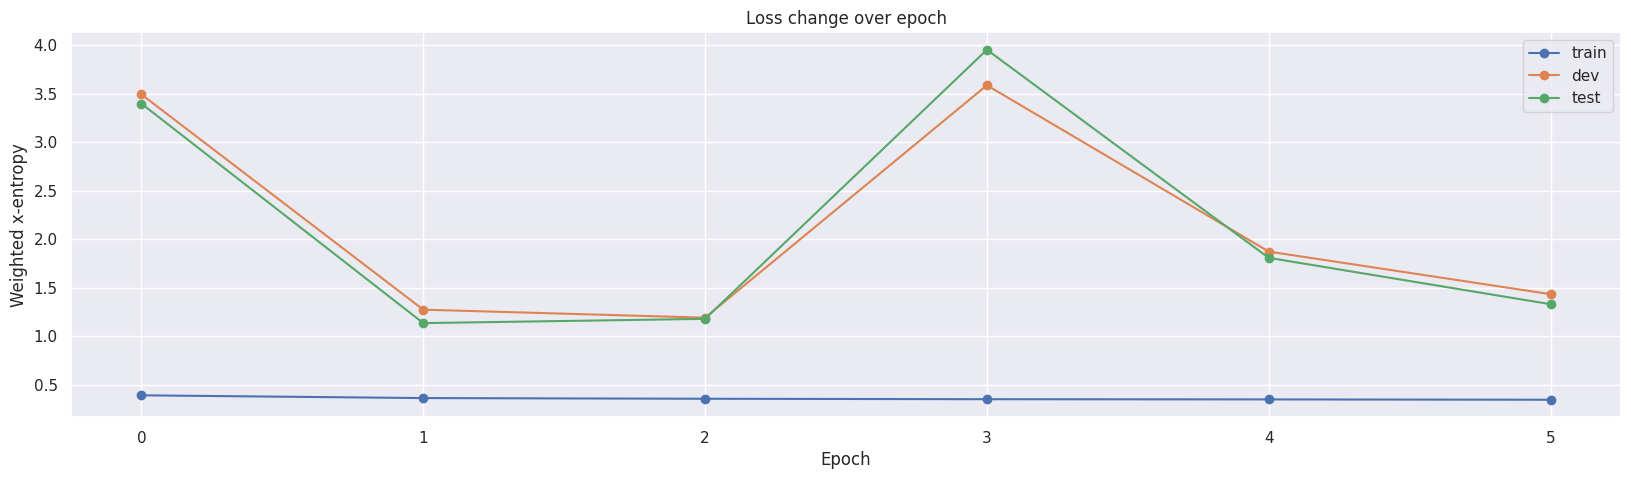

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(losses_df["train"], '-o', label="train")
plt.plot(losses_df["dev"], '-o', label="dev")
plt.plot(losses_df["test"], '-o', label="test")
plt.xlabel("Epoch")
plt.ylabel("Weighted x-entropy")
plt.title("Loss change over epoch")
plt.legend();

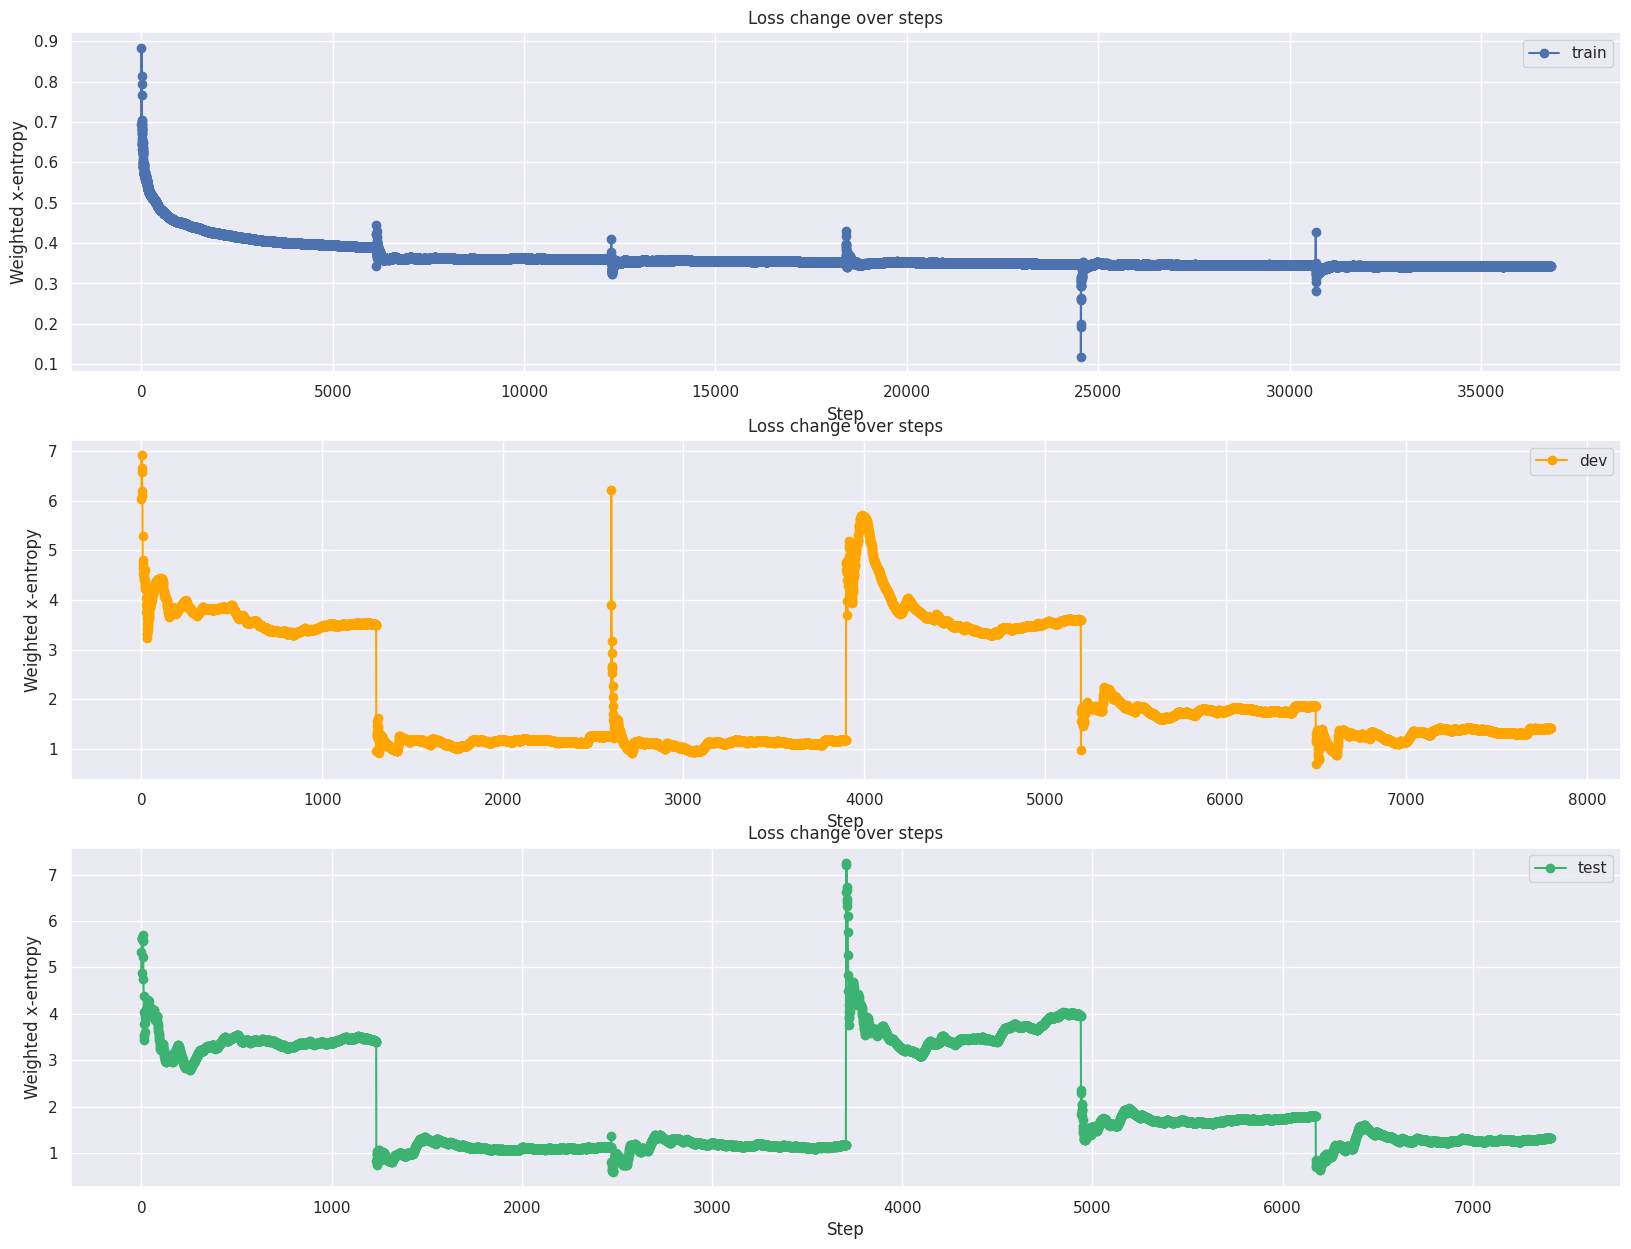

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,15))

ax[0].plot(running_losses_df["train"], '-o', label="train")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Weighted x-entropy")
ax[0].set_title("Loss change over steps")
ax[0].legend();

ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Weighted x-entropy")
ax[1].set_title("Loss change over steps")
ax[1].legend();

ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Weighted x-entropy")
ax[2].set_title("Loss change over steps")
ax[2].legend();

In [ ]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            proba = outputs.cpu().numpy().astype(np.float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]

    predictions_df = predictions_df.dropna()
    return predictions_df

In [ ]:
# When run training for first time to evaluate and create the output files
run_training = True


In [ ]:
if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")

    dev_filename = LOSSES_PATH + "dev_predictions.csv"
    test_filename = LOSSES_PATH + "test_predictions.csv"
    dev_predictions.to_csv(dev_filename, index=False)
    test_predictions.to_csv(test_filename, index=False)

else:

    dev_predictions = pd.read_csv(LOSSES_PATH + "dev_predictions.csv")
    test_predictions = pd.read_csv(LOSSES_PATH + "test_predictions.csv")

    dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "cancer", 0: "no cancer"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])

    labels = ["no cancer", "cancer"]
    index_labels = ["actual no cancer", "actual cancer"]
    col_labels = ["predicted no cancer", "predicted cancer"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

In [ ]:
confusion_df = get_confusion_matrix(dev_predictions['true'], dev_predictions['predicted'])
confusion_df.head()

In [ ]:
confusion_df = get_confusion_matrix(test_predictions['true'], test_predictions['predicted'])
confusion_df.head()

predicted no cancer  predicted cancer
actual no cancer             0.871700          0.128300
actual cancer                0.699254          0.300746

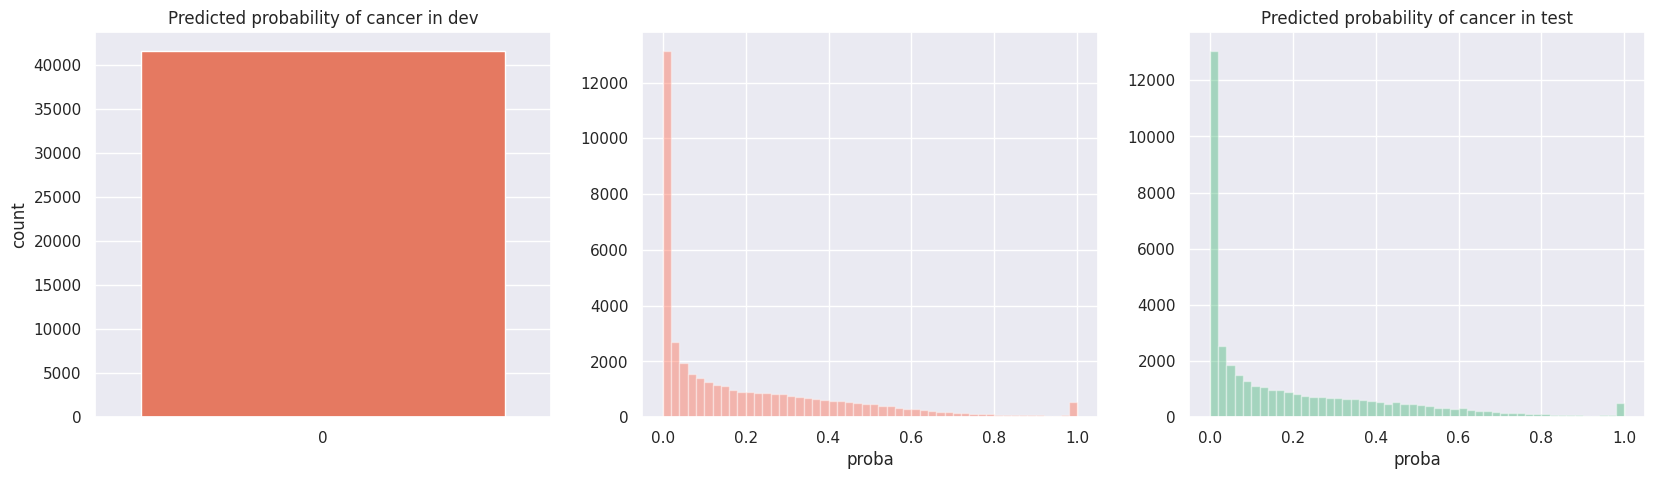

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(dev_predictions.true.astype(np.float), ax=ax[0], palette="Reds_r")
ax[0].set_title("Target counts of dev data");
sns.distplot(dev_predictions.proba.astype(np.float), ax=ax[1], kde=False, color="tomato")
ax[0].set_title("Predicted probability of cancer in dev");
sns.distplot(test_predictions.proba.astype(np.float), ax=ax[2], kde=False, color="mediumseagreen");
ax[2].set_title("Predicted probability of cancer in test");

Batch Size = 64

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

In [ ]:
print(len(dataloaders["train"]), len(dataloaders["dev"]), len(dataloaders["test"]))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
run_training=False
model = torchvision.models.resnet18(pretrained=True)
if run_training:
    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),

    nn.Linear(128, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


In [ ]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.7003, 1.7482], device='cuda:0')


In [ ]:
train_df.target.unique()

array(['0', '1'], dtype=object)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
def f1_score(preds, targets):

    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)

    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

In [ ]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    early_trigger = 5 #if the validation AUC hasn't increased in five epochs, stop the training
    early_stop = 0 #counter for the number of iterations where there has been no increase in validation AUC
    early_stop_happend = False #flag to stop training
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)

    running_loss_dict = {"train": [], "dev": [], "test": []}

    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2

    for epoch in range(num_epochs):
        if early_stop_happend == True:
          break
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)

                        #loss += l2_reg

                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step()
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                counter += 1


                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))

            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' :
              if epoch_acc > best_acc:
                early_stop=0
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
              else:
                early_stop+= 1
              if early_stop == early_trigger:
                print('Early stopping after {} epochs'.format(epoch))
                early_stop_happend = True
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

In [ ]:
start_lr = 1e-6
end_lr = 0.1

In [ ]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular")

    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = np.int(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular")
    return scheduler

In [ ]:
find_learning_rate = True

In [ ]:
MODEL_PATH

'/content/drive/MyDrive/IDC assignment/breastcancermodel/'

In [ ]:
import math

if find_learning_rate:
    lr_find_epochs=1
    optimizer = optim.SGD(model.fc.parameters(), start_lr)
    scheduler = get_lr_search_scheduler(optimizer, start_lr, end_lr, lr_find_epochs*len(train_dataloader))
    results = train_loop(model, criterion, optimizer, lr_find=True, scheduler=scheduler, num_epochs=lr_find_epochs)
    lr_find_lr, lr_find_loss = results["lr_find"]["lr"], results["lr_find"]["loss"]

    find_lr_df = pd.DataFrame(lr_find_loss, columns=["smoothed loss"])
    find_lr_df.loc[:, "lr"] = lr_find_lr
    find_lr_df.to_csv(MODEL_PATH + "learning_rate_search.csv", index=False)
else:
    find_lr_df = pd.read_csv(MODEL_PATH + "learning_rate_search.csv")

Epoch 0/0
----------


  0%|          | 0/3074 [00:00<?, ?it/s]

train Loss: 0.3925 Acc: 0.8293

Training complete in 36m 17s
Best val Acc: 0.000000


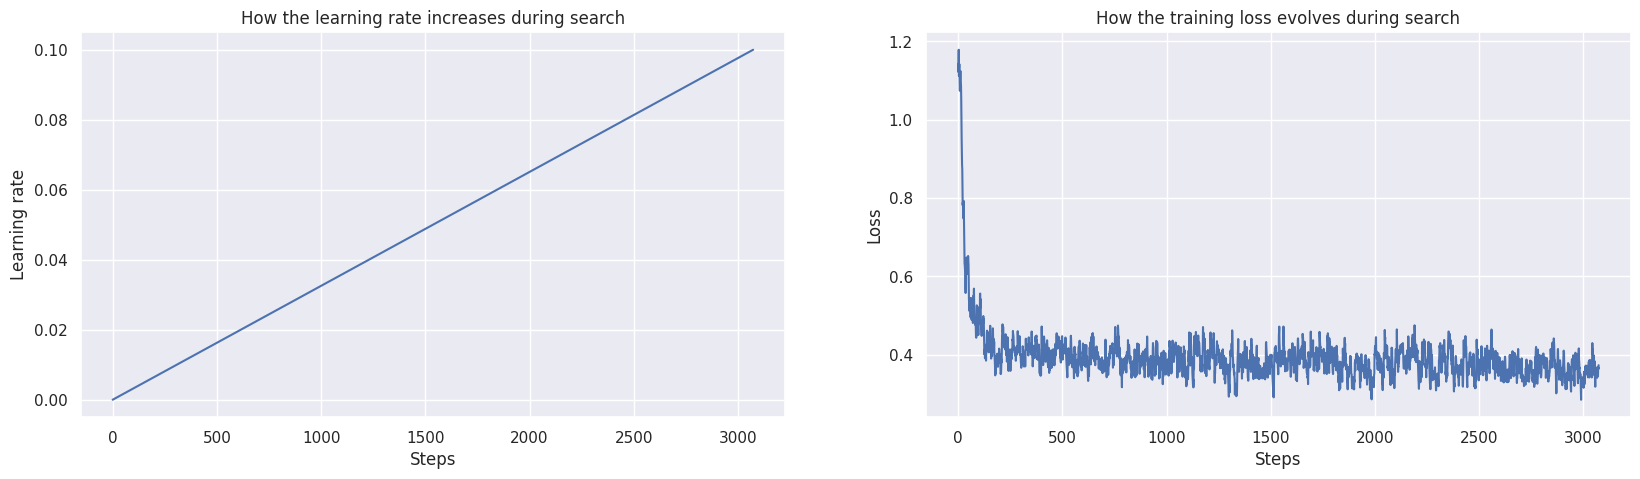

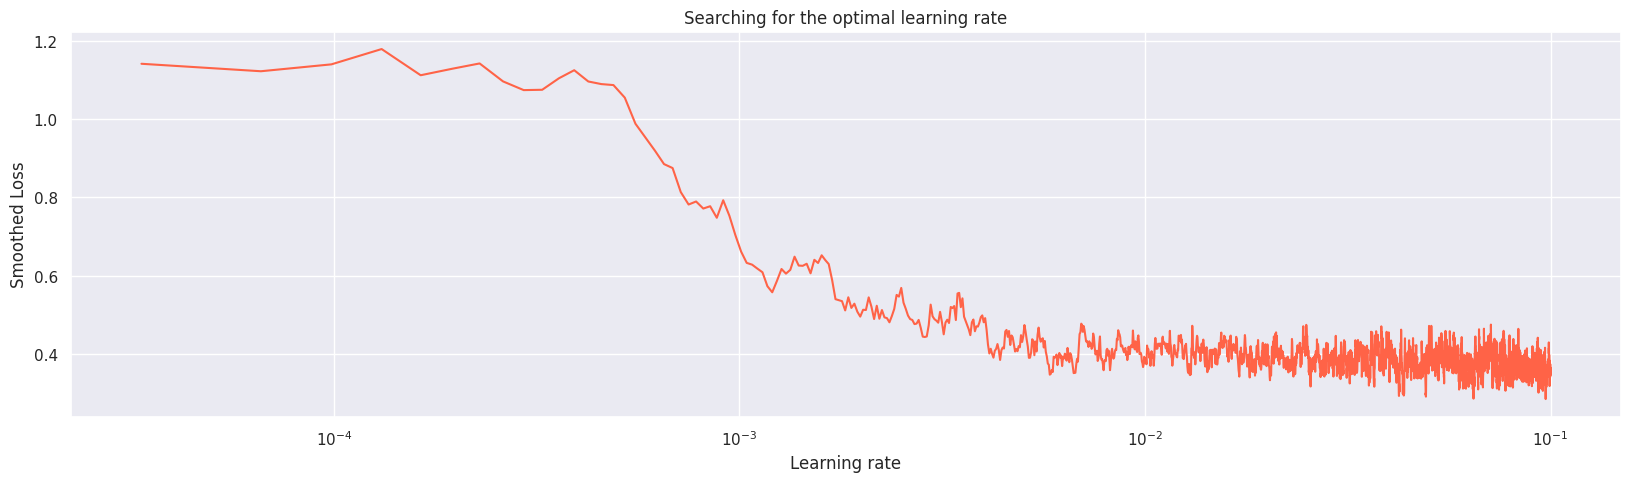

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(find_lr_df.lr.values)
ax[1].plot(find_lr_df["smoothed loss"].values)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Learning rate")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss");
ax[0].set_title("How the learning rate increases during search")
ax[1].set_title("How the training loss evolves during search")

plt.figure(figsize=(20,5))
plt.plot(find_lr_df.lr.values, find_lr_df["smoothed loss"].values, '-', color="tomato");
plt.xlabel("Learning rate")
plt.xscale("log")
plt.ylabel("Smoothed Loss")
plt.title("Searching for the optimal learning rate");

In [ ]:
start_lr = 1e-6
end_lr = 0.1

In [ ]:
run_training = True

In [ ]:
OUTPUT_PATH

'/content/drive/MyDrive/IDC assignment/breastcancermodel/'

## Performing the training or loading results <a class="anchor" id="run"></a>

In [ ]:
if run_training:
  NUM_EPOCHS = 30
  optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
  scheduler = get_scheduler(optimizer, start_lr, end_lr, NUM_EPOCHS)
  results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
  model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]

  if device == "cpu":
      OUTPUT_PATH += ".pth"
  else:
      OUTPUT_PATH += "_cuda.pth"

  torch.save(model.state_dict(), OUTPUT_PATH)

  losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
  losses_df.loc[:, "dev"] = loss_dict["dev"]
  losses_df.loc[:, "test"] = loss_dict["test"]
  losses_df.to_csv(MODEL_PATH +"losses_breastcancer.csv", index=False)

  running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
  running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
  running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
  running_losses_df.to_csv(MODEL_PATH +"running_losses_breastcancer.csv", index=False)
else:
    if device == "cpu":
        load_path = MODEL_PATH + ".pth"
    else:
        load_path = MODEL_PATH + "_cuda_batch_size_64.pth"
    model.load_state_dict(torch.load(load_path, map_location='cpu'))
    model.eval()

    losses_df = pd.read_csv(LOSSES_PATH + "losses_breastcancer.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_breastcancer.csv")

Epoch 0/29
----------


  0%|          | 0/3074 [00:00<?, ?it/s]

train Loss: 0.3816 Acc: 0.8368


  0%|          | 0/628 [00:00<?, ?it/s]

dev Loss: 3.1123 Acc: 0.6996


  0%|          | 0/634 [00:00<?, ?it/s]

test Loss: 3.0125 Acc: 0.7398

Epoch 1/29
----------


  0%|          | 0/3074 [00:00<?, ?it/s]

train Loss: 0.3472 Acc: 0.8500


  0%|          | 0/628 [00:00<?, ?it/s]

dev Loss: 4.0063 Acc: 0.4295


  0%|          | 0/634 [00:00<?, ?it/s]

test Loss: 3.7167 Acc: 0.4333

Epoch 2/29
----------


  0%|          | 0/3074 [00:00<?, ?it/s]

train Loss: 0.3391 Acc: 0.8540


  0%|          | 0/628 [00:00<?, ?it/s]

dev Loss: 2.7544 Acc: 0.5774


  0%|          | 0/634 [00:00<?, ?it/s]

test Loss: 2.2458 Acc: 0.6241

Epoch 3/29
----------


  0%|          | 0/3074 [00:00<?, ?it/s]

train Loss: 0.3343 Acc: 0.8557


  0%|          | 0/628 [00:00<?, ?it/s]

dev Loss: 3.0771 Acc: 0.5598


  0%|          | 0/634 [00:00<?, ?it/s]

test Loss: 2.6399 Acc: 0.5994

Epoch 4/29
----------


  0%|          | 0/3074 [00:00<?, ?it/s]

train Loss: 0.3304 Acc: 0.8577


  0%|          | 0/628 [00:00<?, ?it/s]

dev Loss: 2.9709 Acc: 0.5047


  0%|          | 0/634 [00:00<?, ?it/s]

test Loss: 2.6710 Acc: 0.5227

Epoch 5/29
----------


  0%|          | 0/3074 [00:00<?, ?it/s]

train Loss: 0.3282 Acc: 0.8587


  0%|          | 0/628 [00:00<?, ?it/s]

dev Loss: 5.3731 Acc: 0.4400
Early stopping after 5 epochs


  0%|          | 0/634 [00:00<?, ?it/s]

test Loss: 5.5261 Acc: 0.4385

Training complete in 208m 33s
Best val Acc: 0.699562


# Exploring results and errors <a class="anchor" id="error_analysis"></a>

## Loss convergence <a class="anchor" id="losses"></a>

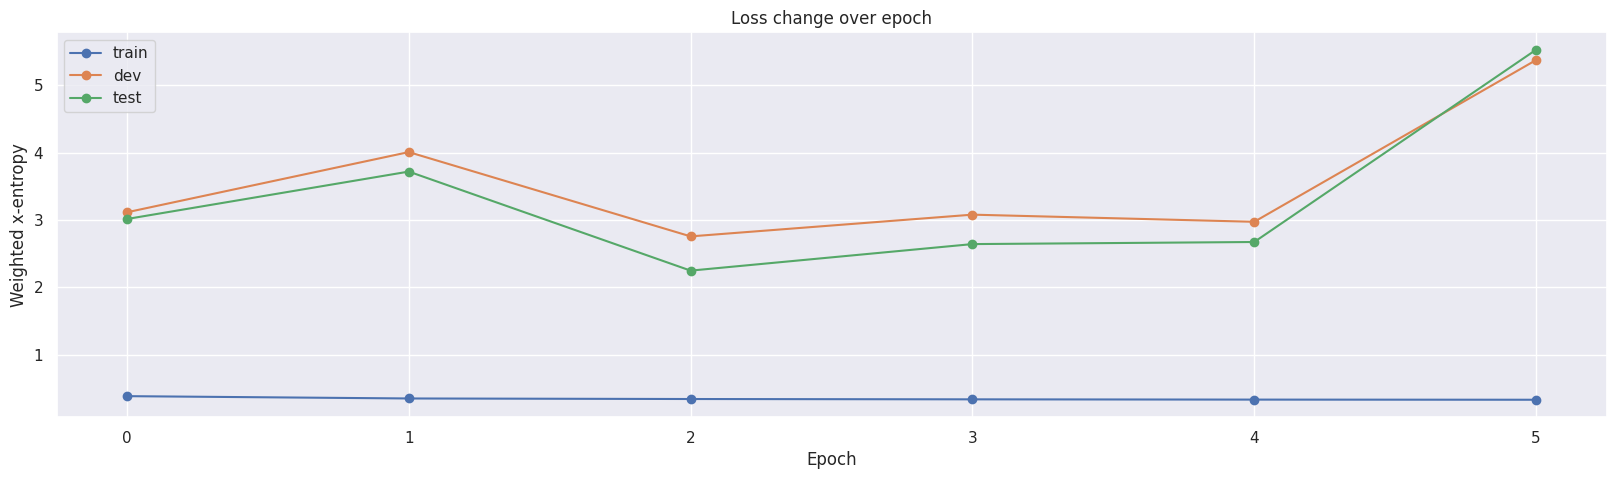

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(losses_df["train"], '-o', label="train")
plt.plot(losses_df["dev"], '-o', label="dev")
plt.plot(losses_df["test"], '-o', label="test")
plt.xlabel("Epoch")
plt.ylabel("Weighted x-entropy")
plt.title("Loss change over epoch")
plt.legend();

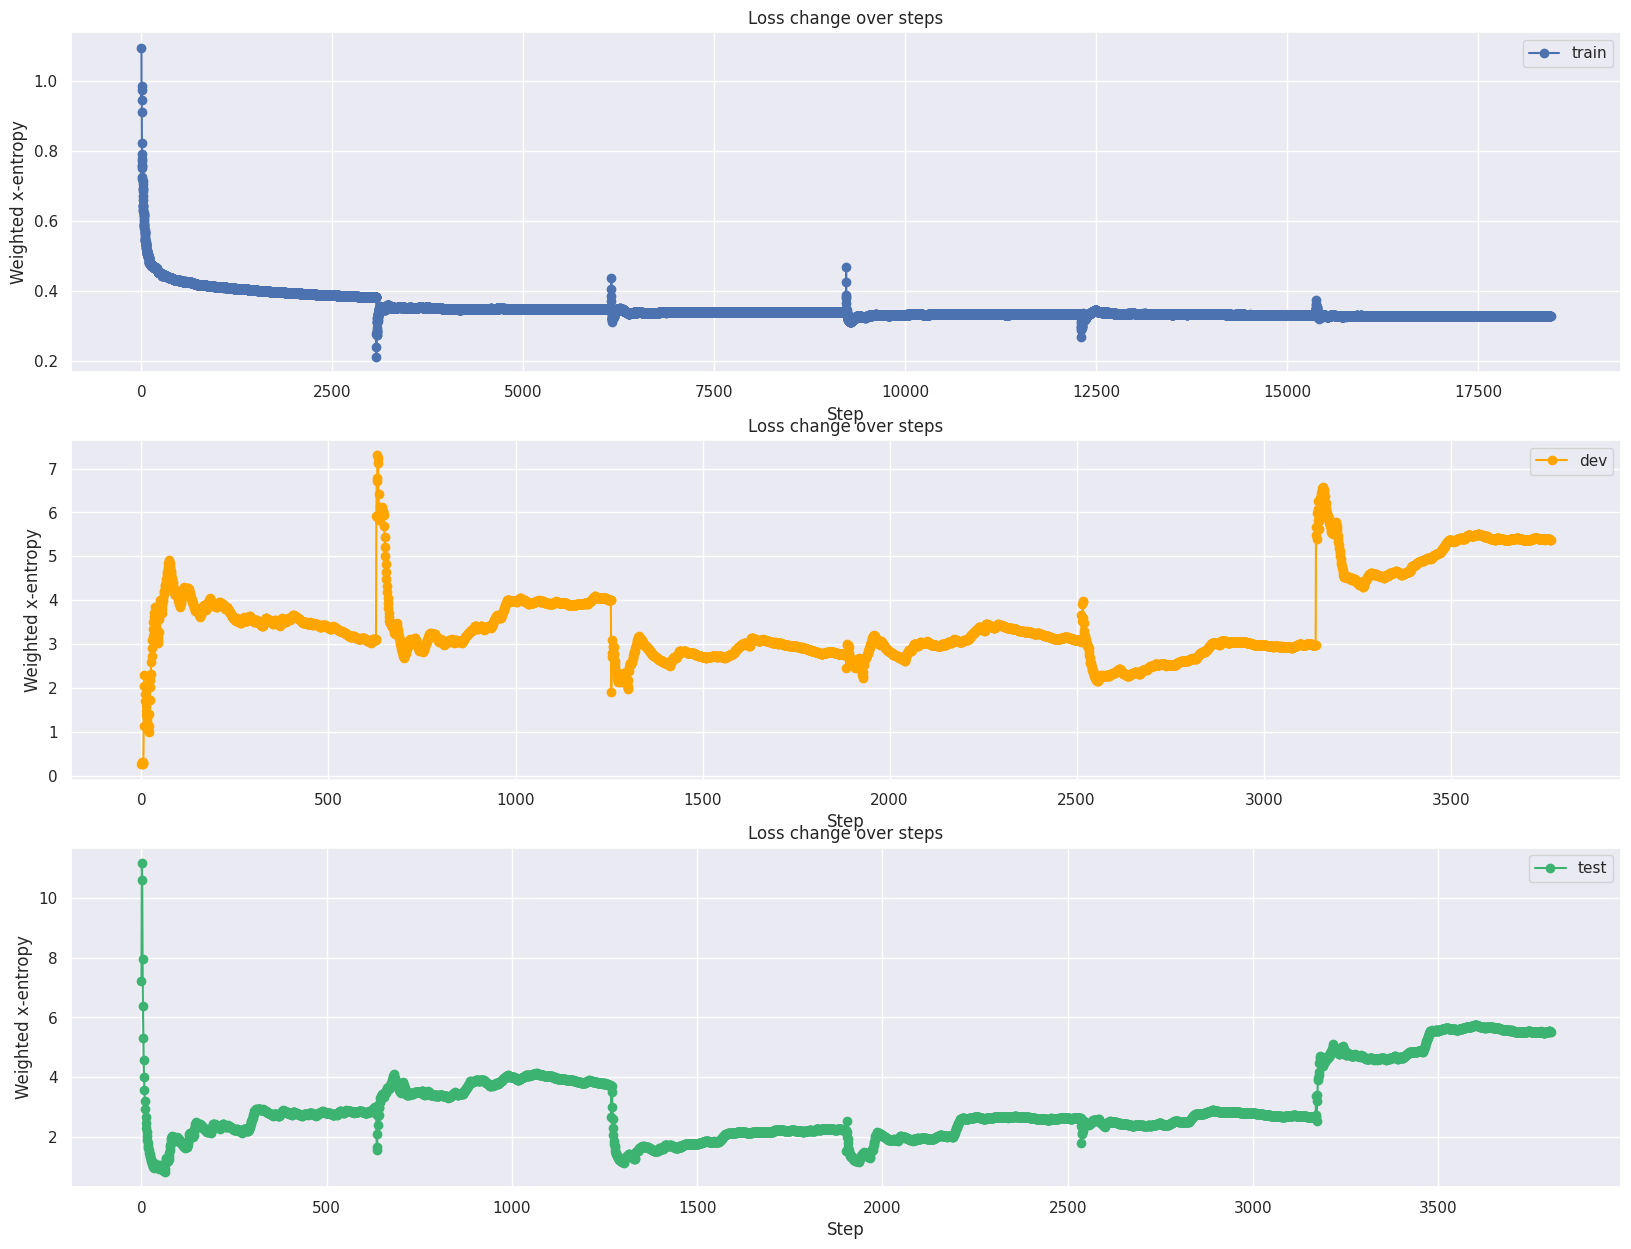

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(20,15))

ax[0].plot(running_losses_df["train"], '-o', label="train")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Weighted x-entropy")
ax[0].set_title("Loss change over steps")
ax[0].legend();

ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Weighted x-entropy")
ax[1].set_title("Loss change over steps")
ax[1].legend();

ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Weighted x-entropy")
ax[2].set_title("Loss change over steps")
ax[2].legend();

In [ ]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            proba = outputs.cpu().numpy().astype(np.float)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "x"] = data["x"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "y"] = data["y"].numpy()
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "patient_id"] = data["patient_id"]

    predictions_df = predictions_df.dropna()
    return predictions_df

In [ ]:
run_training = True

In [ ]:
if run_training:
    dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
    test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

    dev_predictions = evaluate_model(model, dev_predictions, "dev")
    test_predictions = evaluate_model(model, test_predictions, "test")

    dev_filename = LOSSES_PATH + "dev_predictions.csv"
    test_filename = LOSSES_PATH + "test_predictions.csv"
    dev_predictions.to_csv(dev_filename, index=False)
    test_predictions.to_csv(test_filename, index=False)

else:

    dev_predictions = pd.read_csv(LOSSES_PATH + "dev_predictions.csv")
    test_predictions = pd.read_csv(LOSSES_PATH + "test_predictions.csv")

    dev_predictions.patient_id = dev_predictions.patient_id.astype(np.str)

In [ ]:
dev_predictions

true predicted     proba       x       y patient_id
0        0         0  0.000142   151.0  1051.0       9228
1        0         0  0.040271   151.0  1301.0       9228
2        0         0  0.000001   301.0  1551.0       9228
3        0         0  0.167227   801.0   901.0       9228
4        0         0  0.000091  1251.0  2401.0       9228
...    ...       ...       ...     ...     ...        ...
40187    1         0  0.000001  1101.0  1001.0      10258
40188    1         0  0.034213   851.0  1201.0      10258
40189    1         0  0.000124   801.0  1051.0      10258
40190    1         0  0.002982  1151.0   901.0      10258
40191    1         0       0.0  1101.0   601.0      10258

[40192 rows x 6 columns]

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "cancer", 0: "no cancer"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])

    labels = ["no cancer", "cancer"]
    index_labels = ["actual no cancer", "actual cancer"]
    col_labels = ["predicted no cancer", "predicted cancer"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

In [ ]:
confusion_df = get_confusion_matrix(dev_predictions['true'], dev_predictions['predicted'])
confusion_df.head()

predicted no cancer  predicted cancer
actual no cancer             0.923208          0.076792
actual cancer                0.816390          0.183610

In [ ]:
confusion_df = get_confusion_matrix(test_predictions['true'], test_predictions['predicted'])
confusion_df.head()

predicted no cancer  predicted cancer
actual no cancer             0.944099          0.055901
actual cancer                0.855502          0.144498

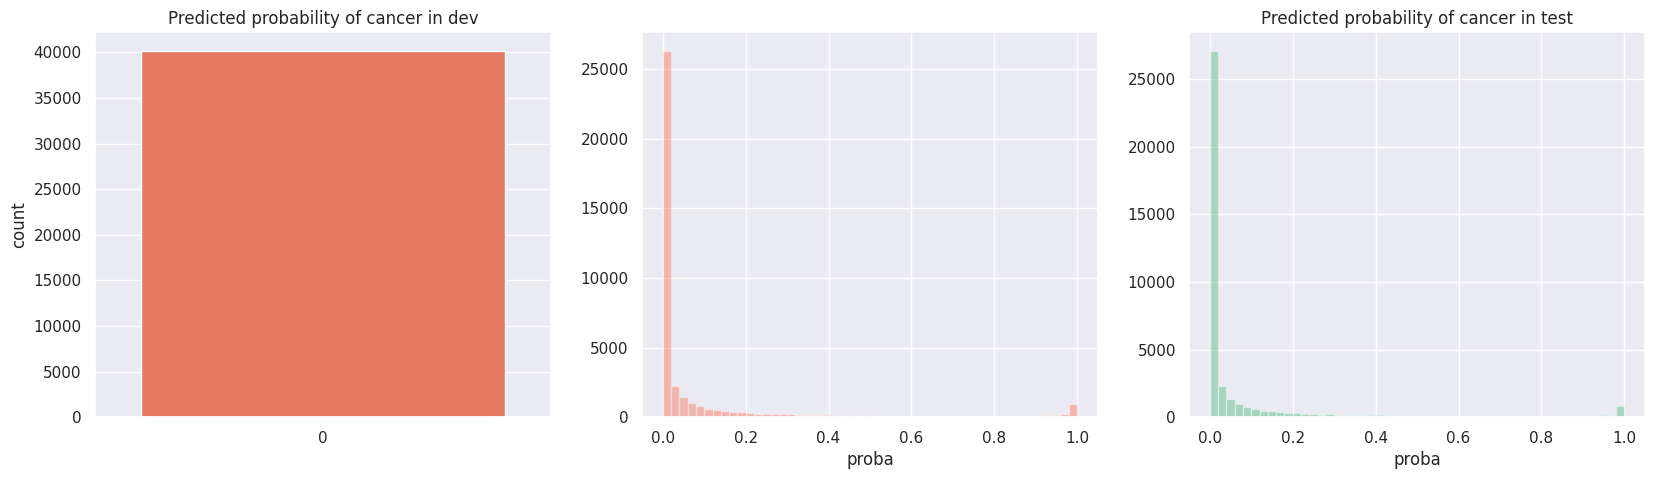

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(dev_predictions.true.astype(np.float), ax=ax[0], palette="Reds_r")
ax[0].set_title("Target counts of dev data");
sns.distplot(dev_predictions.proba.astype(np.float), ax=ax[1], kde=False, color="tomato")
ax[0].set_title("Predicted probability of cancer in dev");
sns.distplot(test_predictions.proba.astype(np.float), ax=ax[2], kde=False, color="mediumseagreen");
ax[2].set_title("Predicted probability of cancer in test");

Compute Confusion Matrix and From Best fitting model

Best model is 32 size

Import Development and Test Predictions

In [ ]:
dev_predictions = pd.read_csv('/content/drive/Shareddrives/IDC Report/breastcancermodellossest32/dev_predictions.csv')
test_predictions = pd.read_csv('/content/drive/Shareddrives/IDC Report/breastcancermodellossest32/test_predictions.csv')

Generate confuction matrices and classifiction reports

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "cancer", 0: "no cancer"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])

    labels = ["no cancer", "cancer"]
    index_labels = ["actual no cancer", "actual cancer"]
    col_labels = ["predicted no cancer", "predicted cancer"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

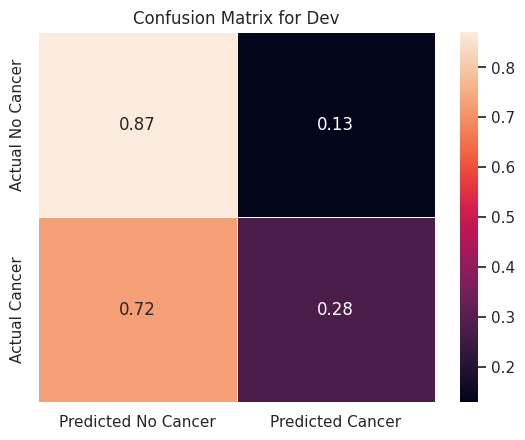

In [ ]:
confusion_df = get_confusion_matrix(dev_predictions['true'], dev_predictions['predicted'])

# Corresponding row and column labelsz+
row_labels = ["Actual No Cancer", "Actual Cancer"]
col_labels = ["Predicted No Cancer", "Predicted Cancer"]

ax = sns.heatmap(confusion_df,
                 linewidth=0.5,
                 annot=True,
                 yticklabels=row_labels,
                 xticklabels=col_labels)
plt.title('Confusion Matrix for Dev')
plt.show()

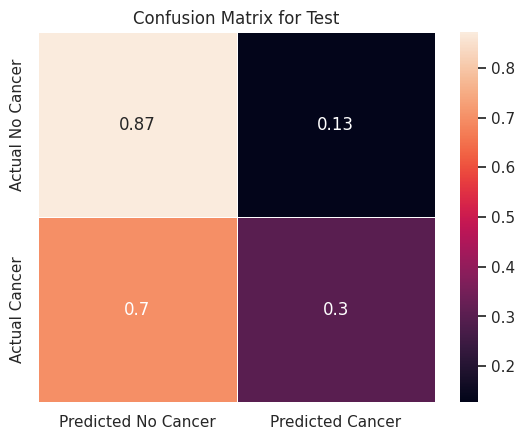

In [ ]:
confusion_df = get_confusion_matrix(test_predictions['true'], test_predictions['predicted'])

# Corresponding row and column labelsz+
row_labels = ["Actual No Cancer", "Actual Cancer"]
col_labels = ["Predicted No Cancer", "Predicted Cancer"]

ax = sns.heatmap(confusion_df,
                 linewidth=0.5,
                 annot=True,
                 yticklabels=row_labels,
                 xticklabels=col_labels)
plt.title('Confusion Matrix for Test')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [ ]:
print("Metric Report for Model Dev\n",classification_report(dev_predictions['true'], dev_predictions['predicted'],target_names= ["No Cancer", "Cancer"]))

Metric Report for Model Dev
               precision    recall  f1-score   support

   No Cancer       0.77      0.87      0.82     30564
      Cancer       0.43      0.28      0.34     11036

    accuracy                           0.71     41600
   macro avg       0.60      0.57      0.58     41600
weighted avg       0.68      0.71      0.69     41600



In [ ]:
print("Metric Report for Model Test\n",classification_report(test_predictions['true'], test_predictions['predicted'],target_names= ["No Cancer", "Cancer"]))

Metric Report for Model Test
               precision    recall  f1-score   support

   No Cancer       0.74      0.87      0.80     27428
      Cancer       0.51      0.30      0.38     12070

    accuracy                           0.70     39498
   macro avg       0.62      0.59      0.59     39498
weighted avg       0.67      0.70      0.67     39498

